# Statistical, computational thresholds and Variance test performance:

Variance algo as described/implemented in:
- https://www.overleaf.com/project/672207ce18cc0a8388a1a7f8
- https://colab.research.google.com/drive/1JbvnecwCdaKpmxhugiLszQ3UXiIQ-dQ0?usp=sharing#scrollTo=BbpIleePIUaN

In [11]:
from scipy import special 
import numpy as np
import math 
import csv
import matplotlib.pyplot as plt

In [12]:
class Variance_algo:
    def __init__(self, p_correction_type="p_reduce"):
        if p_correction_type == "p_reduce":
            self.p0 = 0.5
        elif p_correction_type == "p_increase":
            
            raise NotImplementedError(
                "Variance test for p_increase is not implemented yet."
            )
            
            # TODO: ADAPT VARIANCE TEST IN p_increase CASE

        else:
            raise ValueError(
                "Invalid p_correction_type. Variance test only available for 'p_reduce'"
            )

    def calculate_fraction_correct(self, clique_size, graph_size):
        q_val = clique_size / graph_size
        z_val = (q_val**2 / (1 - q_val**2)) * ((1 - self.p0) / self.p0)

        # Calculating fraction of correct responses (Equation 2):
        return 0.5 + 0.5 * (
            special.erf(np.sqrt(np.log(1 / (1 - z_val)) / z_val))
            - special.erf(np.sqrt(((1 - z_val) / z_val) * np.log((1 / (1 - z_val)))))
        )

    def find_75correct(self, graph_size_or_range):
        # Check if input is a single value or an array
        if isinstance(graph_size_or_range, (int, float)):  # Single value
            return self._find_75correct_singleN(graph_size_or_range)
        elif isinstance(graph_size_or_range, (list, tuple, np.ndarray)):  # Array of values
            results = {}
            for graph_size in graph_size_or_range:
                results[graph_size] = self._find_75correct_singleN(graph_size)
            return results
        else:
            raise ValueError("Input must be a single value or an array of values.")
        

    def _find_75correct_singleN(self, graph_size):

        # Results show that K0 value is above 0.6*graph_size -> start from this value and increment by 1 until fraction_correct > 0.75
        clique_size = int(0.6 * graph_size)
        fraction_correct = self.calculate_fraction_correct(clique_size, graph_size)
        while fraction_correct <= 0.75:
            clique_size += 1
            # Calculating fraction of correct responses (Equation 2):
            fraction_correct = self.calculate_fraction_correct(clique_size, graph_size)
            if clique_size > graph_size:
                raise ValueError(
                    f"K0 value for the variance algorithm is above the graph size {graph_size}. Check code."
                )

        # At the end of the loop, the last clique size value is the one that satisfies the condition:
        k0 = clique_size

        # Making sure that the p_correction is compatible with the defined K0:
        if k0 > (
            (1 + math.sqrt(1 + 4 * self.p0 * graph_size * (graph_size - 1)))
            / 2
        ):
            clique_limit = int(
                (
                    1
                    + math.sqrt(
                        1 + 4 * self.p0 * graph_size * (graph_size - 1)
                    )
                )
                / 2
            )
            raise ValueError(
                f"The k0 value for the variance algorithm is {int(k0)} for graphs of size {graph_size}, which leads to a negative corrected probability of association between nodes. Clique size values have to be lower than {round(clique_limit)}"
            )

        return int(k0)

## Testing Variance algorithm:

In [13]:
# Testing on single N value:
algo = Variance_algo()
k0_single = algo.find_75correct(100)
print(f"K0 for N=100: {k0_single}")

K0 for N=100: 70


In [14]:
# Testing on range of N values:
N_range = np.arange(70, 1200)
k0_multiple = algo.find_75correct(N_range)
print(f"K0 for multiple N values: {k0_multiple}")

K0 for multiple N values: {np.int64(70): 49, np.int64(71): 50, np.int64(72): 50, np.int64(73): 51, np.int64(74): 52, np.int64(75): 52, np.int64(76): 53, np.int64(77): 54, np.int64(78): 55, np.int64(79): 55, np.int64(80): 56, np.int64(81): 57, np.int64(82): 57, np.int64(83): 58, np.int64(84): 59, np.int64(85): 59, np.int64(86): 60, np.int64(87): 61, np.int64(88): 62, np.int64(89): 62, np.int64(90): 63, np.int64(91): 64, np.int64(92): 64, np.int64(93): 65, np.int64(94): 66, np.int64(95): 66, np.int64(96): 67, np.int64(97): 68, np.int64(98): 68, np.int64(99): 69, np.int64(100): 70, np.int64(101): 71, np.int64(102): 71, np.int64(103): 72, np.int64(104): 73, np.int64(105): 73, np.int64(106): 74, np.int64(107): 75, np.int64(108): 75, np.int64(109): 76, np.int64(110): 77, np.int64(111): 77, np.int64(112): 78, np.int64(113): 79, np.int64(114): 80, np.int64(115): 80, np.int64(116): 81, np.int64(117): 82, np.int64(118): 82, np.int64(119): 83, np.int64(120): 84, np.int64(121): 84, np.int64(122): 

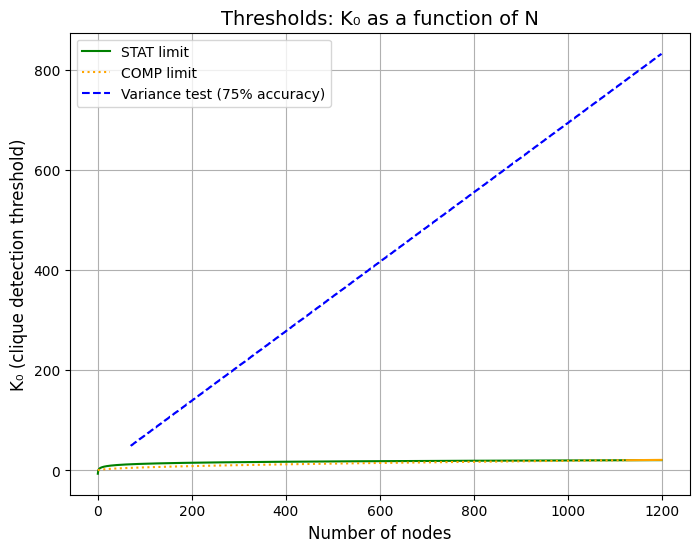

In [15]:
# Create a smaller figure with specified size
fig, ax = plt.subplots(figsize=(8, 6))  

# THEORETICAL AND COMPUTATIONAL LIMITS:
N_range_thresholds = np.arange(0.1, 1200)
K_it = 2 * np.log2(N_range_thresholds)
K_comp = np.sqrt(N_range_thresholds / np.e)            
limits_palette = ['green', 'orange']
ax.plot(N_range_thresholds, K_it, label='STAT limit', color=limits_palette[0])
ax.plot(N_range_thresholds[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
ax.plot(N_range_thresholds[1125:], K_comp[1125:], color=limits_palette[1])

# Variance test:
N_range_variance_test = np.arange(70, 1200)
variance_algo = Variance_algo(p_correction_type="p_reduce")
ax.plot(variance_algo.find_75correct(N_range_variance_test).keys(), variance_algo.find_75correct(N_range_variance_test).values(), label='Variance test (75% accuracy)', color='blue', linestyle='dashed')

# Add a legend to the plot
ax.legend(loc='upper left')

# Add a grid to the plot
ax.grid(True)

# Add axes labels to the plot
ax.set_xlabel('Number of nodes', size=12)
ax.set_ylabel('K₀ (clique detection threshold)', size=12)

ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Set title:
ax.set_title('Thresholds: K₀ as a function of N', size=14)
      
# Save the figure
fig.savefig(f'./plots/thresholds_variance-test/thresholds_K0_vs_N.png', dpi=300, bbox_inches="tight")
fig.savefig(f'./plots/thresholds_variance-test/thresholds_K0_vs_N.svg', dpi=300, bbox_inches="tight")

plt.show()


# Humans:

Note: for this code to work, the 'data/humans' folder needs to contain one sub-folder for each performed experiment. In each of these folders, the data for the different N values must be contained.
Notes:
- there is a reaction time threshold (default=50ms) to exclude trials
- the code assumes a balanced number of subject across K values,  and raises an error if it is unbalanced

In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.special import ndtr
from scipy.optimize import curve_fit
from scipy.stats import spearmanr, shapiro, ttest_rel, ttest_ind, sem, bartlett, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import json
from itertools import combinations
import gzip

## Pipeline:

In [ ]:
class HumanAnalysisPipeline:
    
    def __init__(self, experiment_name, analysis_type="global", log_scale_K0=False, variance_test=False, rt_threshold=50):
        self.experiment_name = experiment_name
        if analysis_type not in ["global", "subject-wise"]:
            raise ValueError("analysis_type must be either 'global' or 'subject-wise'")
        self.analysis_type = analysis_type
        self.log_scale_K0 = log_scale_K0
        self.variance_test = variance_test
        self.rt_threshold = rt_threshold
        
        # Define the path to the experiment directory:
        experiment_path = Path(f'./data/humans/{self.experiment_name}')
        if not experiment_path.exists():
            raise ValueError(f"Experiment directory {experiment_path} does not exist")
        # Check for unbalanced number of files across folders
        folders_N_values = [folder for folder in experiment_path.glob('*') if folder.is_dir()]        
        file_counts = {int(folder.name[1:]): len(list(folder.glob('*.csv'))) for folder in folders_N_values}
        if len(set(file_counts.values())) > 1:  # If file counts are not the same
            unbalanced_N_values = [N for N, count in file_counts.items() if count != max(file_counts.values())]
            raise ValueError(f"Unbalanced number of files detected. N values with issues: {unbalanced_N_values}")
               
        # Generate color palettes
        # - global palette (one color per N value)
        self.humans_palette_global = sns.color_palette("flare", len(folders_N_values))
        # - subjects palette (one color per subject)
        #NOTE: the same color is assigned to subjects having the same number, possible improvement is setting a different palette for each N value
        subjects = [file for file in folders_N_values[0].glob('*.csv') if file.is_file()]
        self.humans_palette_subjects = sns.color_palette("husl", len(subjects))        
        
        # Store list of N values in the current experiment (used to loop through all N values)
        self.N_values = [int(folder.name[1:]) for folder in folders_N_values]
                
    
    def read_raw_data(self):
        print("|Reading raw data...")
        
        # Creating an empty dataframe that will be populated with all the data:
        humans_complete_raw_df = pd.DataFrame()

        # Define the path to the experiment directory:
        experiment_path = Path(f'./data/humans/{self.experiment_name}')

        # Accessing all folders in the specified directory (each folder corresponds to a N value):
        folders = experiment_path.glob('*')
                
        for folder in folders:
            if folder.is_dir():
                print(f"||Entered folder: {folder}")
                
                # Accessing all CSV files in the specified directory:
                files = folder.glob('*.csv')
                
                for file_index, file in enumerate(files):
                    if file.is_file():                        
                        try:
                            # Reading the CSV file:
                            df = pd.read_csv(file)

                            # Concatenating the dataframes (NOTE: assigning a subject number to each file)
                            if self.experiment_name == "2023-06_thesis-data":
                                df['subject_number'] = file_index + 1
                            else:
                                #NOTE (to implement): assign Prolific id instead of subject number? Maybe not, subject number assignment is fine
                                # raise ValueError("IMPLEMENT PROLIFIC ID ASSIGNMENT")
                                df['subject_number'] = file_index + 1
                                
                            humans_complete_raw_df = pd.concat([humans_complete_raw_df, df], axis=0, ignore_index=True)
                            
                        except Exception as e:
                            print(f"Error reading file {file}: {e}")
                            return
                    else:
                        print(f"File {file} does not exist.")
                        return
        
        self.humans_complete_raw_df = humans_complete_raw_df
        display(self.humans_complete_raw_df.head())
            
        print("|Completed reading raw data.")
    
    
    def calculate_demographics(self):
        print("|Calculating demographics.")

        #NOTE: in N-grid experiments, pooling data from all N values, no differentiation between N values in demographics
        
        # isolating survey trials to calculate average age:
        humans_survey = self.humans_complete_raw_df[self.humans_complete_raw_df.trial_type == "survey-html-form"]
        # initializations:
        age = []    # list to store ages
        female_count = 0
        male_count = 0
        transgender_count = 0
        other = 0
        not_specified = 0
        # accessing ages and storing them:
        for index, row in humans_survey.iterrows():            
            try:
                response_dict = json.loads(row.response)
                # appending age to the list:
                age.append(int(response_dict['age']))
                # incrementing gender count:
                match response_dict['gender']:
                    case "female":
                        female_count += 1
                    case "male":
                        male_count += 1
                    case "transgender":
                        transgender_count += 1
                    case "other":
                        other += 1
                    case "not-specified":
                        not_specified += 1
                    case _:
                        return "Other"
                
            except ValueError:
                print(f"Error reading dictionary for row {index}.")                            
        
        # calculating average age and total female count:
        try:
            average_age = np.mean(age)
            print(f"Average age: {average_age}")
        except ZeroDivisionError:
            print("Error calculating average age: No valid age data found")
        
        if self.experiment_name == "2023-06_thesis-data":
            # in thesis data, same subjects performed the experiment at N=300 and N=1000, so we need to divide by 2
            female_count =  female_count / 2
            male_count = male_count / 2    
        print(f"Female count: {female_count}")
        print(f"Male count: {male_count}")
        print(f"Transgender count: {transgender_count}")
        print(f"Other count: {other}")
        print(f"Not specified count: {not_specified}")
        
        print("|Completed calculating demographics.")
            
    
    # def calculate_devices_stats(self):
    
    #TODO:
    # - analyze the different devices used by the subjects (from device_check plugin) 
    # - save p-correction type in attribute (to be used in strategy exploration)
    
     
    def clean_data(self):
        print("|Cleaning data...")
        
        try:
            # cleaning raw data to access only relevant variables:
            # - isolating experiment trials ("canvas-keyboard-response" ones) and dropping irrelevant variables:
            cleaned_df = self.humans_complete_raw_df[self.humans_complete_raw_df.trial_type == "canvas-keyboard-response"]
            # - dropping irrelevant variables:
            if self.experiment_name == "2023-06_thesis-data":
                cleaned_df = cleaned_df.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus","graphs_couple"], axis=1).copy()
            else:
                cleaned_df = cleaned_df.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus","height","webaudio","browser","browser_version","mobile","os","fullscreen","vsync_rate","webcam","microphone", "value", "width"], axis=1).copy()                        

            # adding controls on final responses before filtering out trials based on reaction times:
            final_responses = cleaned_df[cleaned_df['response'].isin(['arrowright', 'arrowleft'])]
            # 1. checking that graph sizes in the experiment folder corresponds to the graph sizes in the cleaned data:
            N_values_final_responses = final_responses['graph_size'].unique()
            for N_value_final_responses in N_values_final_responses:
                if not N_value_final_responses in self.N_values:
                    raise ValueError(f"N value {N_value_final_responses} is present in the data but not in the list of N values. Check that the data inside the folders corresponds to the N value indicated by the folder name.")
           
            # TODO: UNCOMMENT THIS CONTROL WHEN DATA IS FINAL
           
            # # 2. checking that all subjects have the expected number of final responses for each K value (12 trials per K value):
            # final_responses_per_K_value = final_responses.groupby(['graph_size', 'clique_size', 'subject_number']).size().reset_index(name='trials_per_K_value')
            # # Identify problematic rows where the count is not equal to 12
            # problematic_rows = final_responses_per_K_value[final_responses_per_K_value['trials_per_K_value'] != 12]
            # if not problematic_rows.empty:
            #     # Include graph_size, clique_size, subject_number, and trials_per_K_value in the error details
            #     error_details = problematic_rows[['graph_size', 'subject_number', 'clique_size', 'trials_per_K_value']].to_dict(orient='records')
            #     raise ValueError(f"Not all subjects have 12 trials per K value. Problematic entries: {error_details}")

            # excluding trials where response times are less than the threshold:
            #NOTE: rt<50ms trials are excluded from all analyses 
            cleaned_df_filtered = cleaned_df[cleaned_df['rt'].values >= self.rt_threshold]
            excluded_trials = len(cleaned_df) - len(cleaned_df_filtered)  
            print(f'Excluding {excluded_trials} trials where response time is less than {self.rt_threshold}ms. {len(cleaned_df_filtered)} trials remaining. Excluded {round((excluded_trials/len(cleaned_df))*100, 2)}% of trials.')

            # differentiating trials:
            # - final responses
            self.cleaned_data_final_resp = cleaned_df_filtered[cleaned_df_filtered['response'].isin(['arrowright','arrowleft'])]
            # - shuffle trials
            self.cleaned_data_shuffles = cleaned_df_filtered[cleaned_df_filtered['response'].isin([' '])]
            # - response times (keeping both shuffles and final responses)
            self.cleaned_data_response_times = cleaned_df_filtered.copy()           

            print(self.cleaned_data_response_times.tail())
            
        except Exception as e:
            print(f"Error cleaning data: {e}")
        
        print("|Completed cleaning data.")
        
        
    def calculate_fraction_correct(self):
        print("|Calculating fraction correct...")
            
        # initializations:
        df_humans_fraction_correct_appended = []
        for N_value in sorted(self.N_values):
            # isolating data of current N value:
            currentN_data = self.cleaned_data_final_resp[self.cleaned_data_final_resp.graph_size == N_value]            
            # isolating the single values of K:
            K_range = currentN_data['clique_size'].unique()
            for K_value in K_range:
                if self.analysis_type == "global":
                    # isolating data of current clique size:
                    currentK_data = currentN_data[currentN_data.clique_size == K_value]
                    # calculating accuracy for current clique size ("correct", when present, is either True or False)
                    if self.experiment_name == "2023-06_thesis-data":
                        fraction_correct_currentK = sum(currentK_data.accuracy) / sum(~ currentK_data.accuracy.isna())
                    else:
                        fraction_correct_currentK = sum(currentK_data.correct) / sum(~ currentK_data.correct.isna())
                    # appending data to the list:
                    df_humans_fraction_correct_appended.append(pd.DataFrame({'N':[N_value], 'K':[K_value], 'fc':[fraction_correct_currentK]}))
                elif self.analysis_type == "subject-wise":
                    for subject_number in currentN_data['subject_number'].unique():

                        print(f"Subject {subject_number}, N = {N_value}, K = {K_value}")
                        
                        # isolating data of current clique size and subject number:
                        currentK_data = currentN_data[(currentN_data.clique_size == K_value) & (currentN_data.subject_number == subject_number)]
                        
                        print(currentK_data.head())
                        
                        # calculating accuracy
                        if self.experiment_name == "2023-06_thesis-data":
                            fraction_correct_currentK = sum(currentK_data.accuracy) / sum(~ currentK_data.accuracy.isna())
                        else:
                            fraction_correct_currentK = sum(currentK_data.correct) / sum(~ currentK_data.correct.isna())
                        # appending data to the list:
                        df_humans_fraction_correct_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K':[K_value], 'fc':[fraction_correct_currentK]}))
                else:
                    raise ValueError("Invalid analysis type")

        # creating single df for current N value:   
        df_humans_fraction_correct = pd.concat(df_humans_fraction_correct_appended)
        # creating new variable and adding it to the dataframe:
        df_humans_fraction_correct['K/sqrt(N)'] = df_humans_fraction_correct['K']/np.sqrt(df_humans_fraction_correct['N'])
        # creating new variable and adding it to the dataframe:
        df_humans_fraction_correct['K/N'] = df_humans_fraction_correct['K']/df_humans_fraction_correct['N']
        # saving dataframe:
        self.df_humans_fraction_correct = df_humans_fraction_correct
        # visualizing dataframe:
        display(df_humans_fraction_correct)  
        print("|Completed calculating fraction correct.")      
    
    def generate_boxplot(self):
    # Description:
    # Boxplot to compare the fraction of correct responses at different N values (emerging trend: larger N -> larger fraction correct)  

        print("|Generating boxplot...") 
        
        # creating unique figure (width variable baed on N values):
        fig, ax = plt.subplots(figsize=(3 * len(self.df_humans_fraction_correct['N'].unique()), 4))
                
        ax.set_xlim([80, 1020])
        ax.set_ylim([0.5, 1])        
        
        if self.analysis_type == "global":
            # creating dataframe containing only data to plot
            average_fc_df = self.df_humans_fraction_correct.groupby(['N'])['fc'].mean().reset_index()            
            ax.scatter(sorted(self.N_values), average_fc_df.groupby('N')['fc'].mean().values, color=self.humans_palette_global, s=120, marker='o')
        elif self.analysis_type == "subject-wise":
            # creating dataframe containing only data to plot
            average_fc_df = self.df_humans_fraction_correct.groupby(['subject_number', 'N'])['fc'].mean().reset_index()
            # swarmplot with single subjects:
            ax = sns.stripplot(data=average_fc_df, x='N', y='fc', hue='subject_number', palette=self.humans_palette_subjects, s=7, alpha=0.7, legend=False)
            # adding corresponding mean value as a point over each swarmplot:
            ax.scatter([str(i) for i in sorted(self.N_values)], average_fc_df.groupby('N')['fc'].mean().values, color=self.humans_palette_global, s=120, marker='o')

        # Generate legend for average points:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=self.humans_palette_global[i], markersize=10) for i in range(len(self.N_values))]
        ax.legend(handles, [f'N = {i}' for i in sorted(self.N_values)], title='Average fraction correct', loc='center left', bbox_to_anchor=(1, 0.5))
                
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel('Fraction correct', size=12)
        ax.set_title('Fraction correct as a function of N', size=14)
        
        # saving figure in corresponding "plots/humans" folder
        plt.savefig(f'./plots/humans/{self.experiment_name}/humans-boxplot_{self.experiment_name}{"_global" if self.analysis_type == "global" else "_subjects"}.svg', dpi=300, bbox_inches="tight")
        plt.savefig(f'./plots/humans/{self.experiment_name}/humans-boxplot_{self.experiment_name}{"_global" if self.analysis_type == "global" else "_subjects"}.png', dpi=300, bbox_inches="tight")
       
        plt.show()
        
        print("|Completed generating boxplot.")
        
        
    def calculate_boxplot_stats(self):
        # Description:
        # - comparing mean fraction correct at different N values to check if they differ significantly.
        # NOTE:
        # 1. this is a global analysis (no subject information)
        # 2. differentiating test based on the number of N values (ANOVA for more than 2 N values, t-test for 2 N values)
        # 3. not creating dataframe, only printing values
        # 4. not imposing directionality in the tests (two-tailed tests), but seems like fraction correct increases with N (alternative='less')
        
        # creating dataframe containing only data to analyze
        if self.analysis_type == "global":
            average_fc_df = self.df_humans_fraction_correct.groupby(['N'])['fc'].mean().reset_index()
        elif self.analysis_type == "subject-wise":
            average_fc_df = self.df_humans_fraction_correct.groupby(['subject_number', 'N'])['fc'].mean().reset_index()        
        
        # calculating mean and standard error of the mean for all N values:
        for N_value in sorted(self.N_values):
            print(f"Mean fraction correct for N = {N_value}: {average_fc_df[average_fc_df['N'] == N_value]['fc'].mean()} +- {sem(average_fc_df[average_fc_df['N'] == N_value]['fc'])}")
        
        # differentiating analysis based on number of N values:
        if len(self.N_values) == 2:
            print("|Calculating boxplot stats (2 N values -> t-test)...")
            # checking t-test assumptions:
            # - normality
            print("Shapiro-Wilk test for normality:")
            print(f"- for {sorted(self.N_values)[0]}: {shapiro(average_fc_df[average_fc_df['N'] == sorted(self.N_values)[0]]['fc'])}")
            print(f"- for {sorted(self.N_values)[1]}: {shapiro(average_fc_df[average_fc_df['N'] == sorted(self.N_values)[1]]['fc'])}")                        
            # performing t-test:            
            if self.experiment_name == "2023-06_thesis-data":
                print("thesis data")
                # in the thesis data, the two samples are dependent (same subjects)
                t_test_stat = ttest_rel(average_fc_df[average_fc_df['N'] == sorted(self.N_values)[0]]['fc'], average_fc_df[average_fc_df['N'] == sorted(self.N_values)[1]]['fc'])
            else:
                # in general, the two samples are independent (different subjects)
                t_test_stat = ttest_ind(average_fc_df[average_fc_df['N'] == sorted(self.N_values)[0]]['fc'], average_fc_df[average_fc_df['N'] == sorted(self.N_values)[1]]['fc'])
            # printing t-test results 
            print(f"t-statistic: {t_test_stat.statistic}, p-value: {t_test_stat.pvalue}")            
                 
        elif len(self.N_values) > 2:
            # NOTE: assuming the sample size >= 30 for each N value and that samples are independent
            
            print("|Calculating boxplot stats (more than 2 N values -> ANOVA)...")
            # checking ANOVA assumptions (normality and homogeneity of variances):
            # - normality
            print("Shapiro-Wilk test for normality:")
            for N_value in sorted(self.N_values):
                print(f"- for {N_value}: {shapiro(average_fc_df[average_fc_df['N'] == N_value]['fc'])}")
            # - homogeneity of variances
            print("Bartlett test for homogeneity of variances:")
            print(f"- for all N values: {bartlett([average_fc_df[average_fc_df['N'] == N_value]['fc'] for N_value in sorted(self.N_values)])}")            
            # performing ANOVA test:
            anova_stat = f_oneway(*[average_fc_df[average_fc_df['N'] == N_value]['fc'] for N_value in sorted(self.N_values)])
            print(f"ANOVA statistic: {anova_stat.statistic}, p-value: {anova_stat.pvalue}")
            # based on the result of the One-way Anova, perform post-hoc tests to determine which N values differ significantly from each other 
            # (...)
        else:
            raise ValueError("Only one N value, cannot perform statistical test")
                
            
    def calculate_fitted_params(self):
        print("|Calculating fitted parameters...")
        
        def sigmoid(k, k0, delta):
            return (1+ndtr((k-k0)/delta))/2 
        
        # empty dataframe where fitted parameters will be stored:
        df_humans_fitted_params_appended = []
        
        # looping through all N values:
        for N_value in sorted(self.N_values):
            # selecting trials for current N value:
            current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N']==N_value]
            if self.analysis_type == "global":
                # calculating fitted parameters:
                fitted_params = curve_fit(sigmoid, current_data['K'], current_data['fc'], p0=(70, 20))[0]
                # adding fitted parameters to the dataframe (K0 and Delta):
                df_humans_fitted_params_appended.append(pd.DataFrame({'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))
            elif self.analysis_type == "subject-wise":
                # looping through all subjects for current N value:
                for subject in current_data['subject_number'].unique():
                    # accessing data for current subject:
                    current_subject_data = current_data[current_data['subject_number'] == subject]
                    # calculating fitted parameters:
                    fitted_params = curve_fit(sigmoid, current_subject_data['K'], current_subject_data['fc'], p0=(70, 20))[0]
                    # adding fitted parameters to the dataframe:
                    df_humans_fitted_params_appended.append(pd.DataFrame({'subject_number':[subject], 'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))

        # concatenating dataframe of fitted parameters:
        df_humans_fitted_params = pd.concat(df_humans_fitted_params_appended)
        # saving dataframe:
        self.df_humans_fitted_params = df_humans_fitted_params
        # visualizing dataframe:
        display(df_humans_fitted_params)
        print("|Completed calculating fitted parameters.")
    
    
    def generate_psychometrics(self):
        print("|Generating psychometric curves...")
        
        # defining x values:
        x_vals = np.linspace(0, 0.4*max(self.df_humans_fraction_correct['N'].unique()), 1000)       
        
        # DRAWING THE PSYCHOMETRIC CURVES
        if self.analysis_type == "global":
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            # - two subplots showing the global psychometric curves. The one on the left shows K on x-axis, the one on the right shows K/N on x-axis.
            # - K on x-axis:
            sns.scatterplot(data=self.df_humans_fraction_correct, x='K', y='fc', ax=ax[0], s=10, hue='N', palette=self.humans_palette_global)
            # - K/N on x-axis:
            sns.scatterplot(data=self.df_humans_fraction_correct, x='K/N', y='fc', ax=ax[1], s=10, hue='N', palette=self.humans_palette_global)
            for i, N_value in enumerate(sorted(self.N_values)):
                # defining y values for the psychometric curve: 
                k0 = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value)]['K0'].values[0]
                delta = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value)]['Delta'].values[0]
                y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                # creating dataframe to plot the line using seaborn:
                df_line = pd.DataFrame({'N': N_value, 'K': x_vals, 'fc': y_vals})
                df_line['K/N'] = df_line['K']/df_line['N']
                # plotting the psychometric curve:
                sns.lineplot(data=df_line, x='K', y='fc', ax=ax[0], color=self.humans_palette_global[i])  
                sns.lineplot(data=df_line, x='K/N', y='fc', ax=ax[1], color=self.humans_palette_global[i])                          
            
            ax[0].set_ylabel("Fraction correct")
            ax[0].set_xlabel("Clique size")
            ax[0].tick_params(axis='x')
            ax[0].tick_params(axis='y')
            ax[0].set_title("Psychometric curves (K on x-axis)")
            ax[1].set_ylabel("Fraction correct")
            ax[1].set_xlabel("Clique size / N")
            ax[1].set_xlim(ax[1].get_xlim()[0], 0.6)
            ax[1].tick_params(axis='x')
            ax[1].tick_params(axis='y')
            ax[1].set_title("Psychometric curves (K/N on x-axis)") 
            
            # adjusting layout and saving figure:
            plt.tight_layout()
            # saving figure in corresponding "plots/humans" folder       
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-psychometric-curves_{self.experiment_name}_global.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-psychometric-curves_{self.experiment_name}_global.png', dpi=300, bbox_inches="tight")  
                
        elif self.analysis_type == "subject-wise":     
            # - create subplots based on the number of N values and subjects:
            n_values = len(self.df_humans_fraction_correct['N'].unique())
            subjects = len(self.df_humans_fraction_correct['subject_number'].unique())    
            fig, ax = plt.subplots(n_values, subjects, figsize=(5 * subjects, 4 * n_values), constrained_layout=True)

            # - loop through the N values:
            for i, N_value in enumerate(sorted(self.N_values)):
                # isolating data for current N value:
                current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N'] == N_value]
        
                # defining y values and plotting the scatterplot and the psychometric curve:
                for j, subject_number in enumerate(current_data['subject_number'].unique()):
                    # drawing scatterplot based on fraction correct dataframe:
                    subject_data = current_data[current_data['subject_number'] == subject_number]
                    sns.scatterplot(data=subject_data, x='K', y='fc', color=self.humans_palette_subjects[j], ax=ax[i, j], s=10)
                    # defining y values and plotting the psychometric curve:
                    k0 = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value) & (self.df_humans_fitted_params['subject_number'] == subject_number)]['K0'].values[0]
                    delta = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value) & (self.df_humans_fitted_params['subject_number'] == subject_number)]['Delta'].values[0]
                    y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                    ax[i, j].plot(x_vals, y_vals, color=self.humans_palette_subjects[j], label=f'Subject {subject_number}')
                    ax[i, j].set_ylabel("Fraction correct")
                    ax[i, j].set_xlabel("Clique size")    
                    ax[i, j].tick_params(axis='x')
                    ax[i, j].tick_params(axis='y')
                    ax[i, j].set_title(f"N = {int(N_value)}, Subject {subject_number}")

            # adjusting layout and saving figure:
            plt.tight_layout()
            # saving figure in corresponding "plots/humans" folder
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-psychometric-curves_{self.experiment_name}_subjects.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-psychometric-curves_{self.experiment_name}_subjects.png', dpi=300, bbox_inches="tight")
                                         
        else:
            raise ValueError("Invalid analysis type")
              
         
        # Show the plot
        plt.show()
    
        print("|Completed generating psychometric curves.")
        
        
    def calculate_shuffles_df(self):
        print("|Calculating shuffles dataframe...")
        
        # initializations:
        df_humans_mean_shuffles_appended = []
        
        # retrieving the number of trials for a given clique size value in the whole experiment (used to normalize the number of shuffles):
        N_trials_per_K_value = self.cleaned_data_final_resp.groupby(['graph_size', 'clique_size', 'subject_number']).size().reset_index(name='count')
        print("Number of trials per clique size in the whole exp:", N_trials_per_K_value['count'].iloc[0])
        
        # looping through all N values, clique size values and subjects
        for N_value in sorted(self.N_values):
            currentN_data = self.cleaned_data_final_resp[self.cleaned_data_final_resp.graph_size == N_value]
            # looping through all K values for current N value:
            for K_value in currentN_data['clique_size'].unique():
                currentK_data = currentN_data[currentN_data.clique_size == K_value]
                # looping through all subjects for current N and K values:
                for subject_number in currentK_data['subject_number'].unique():
                    # isolating data of current N value, K value and subject number (NOTE: using self.cleaned_data_shuffles here)
                    currentK_subject_shuffles = self.cleaned_data_shuffles[(self.cleaned_data_shuffles.graph_size == N_value) & (self.cleaned_data_shuffles.clique_size == K_value) & (self.cleaned_data_shuffles.subject_number == subject_number)]
                    # counting the number of shuffles for current subject for current N and K values:
                    mean_shuffles_subject = len(currentK_subject_shuffles) / N_trials_per_K_value['count'].iloc[0]  # normalizing by the number of trials for a given clique size value in the whole experiment
                    # appending data to the list:
                    df_humans_mean_shuffles_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K': [K_value], 'mean_shuffles':[mean_shuffles_subject]}))

        # creating single df:   
        df_humans_shuffles = pd.concat(df_humans_mean_shuffles_appended)
        # creating new variable and adding it to the dataframe:
        df_humans_shuffles['K/N'] = df_humans_shuffles['K']/df_humans_shuffles['N']
        # saving dataframe:
        self.df_humans_shuffles = df_humans_shuffles
        # visualizing dataframe:
        display(self.df_humans_shuffles)  
                
        print("|Completed calculating shuffles dataframe.")
        
    
    def generate_shuffles_graphs(self):
        
        print("|Generating shuffles graphs...")

        if self.analysis_type == "global":                    
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            # - K on x-axis:
            sns.lineplot(data = self.df_humans_shuffles, x = 'K', y = 'mean_shuffles', hue='N', palette=self.humans_palette_global, errorbar='se', linestyle='-', marker='o', ax=ax[0])
            # - K/N on x-axis:
            sns.lineplot(data = self.df_humans_shuffles, x = 'K/N', y = 'mean_shuffles', hue='N', palette=self.humans_palette_global, errorbar='se', linestyle='-', marker='o', ax=ax[1])

            # plotting K0s as vertical red dashed lines:
            for i, N_value in enumerate(sorted(self.N_values)):
                K0 = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].values[0]
                ax[0].axvline(K0, color=self.humans_palette_global[i], linestyle='--', linewidth=1.5)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax[0].text(K0+0.5, 3, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
                ax[1].axvline(K0/N_value, color=self.humans_palette_global[i], linestyle='--', linewidth=1.5)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax[1].text(K0/N_value+0.005, 3, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
            
                # setting labels and title:
                ax[0].set_xlim(ax[0].get_xlim()[0], 320)
                ax[0].set_ylim(-0.5, 4)
                ax[0].set_ylabel("Number of shuffles")
                ax[0].set_xlabel("Clique size")
                ax[0].tick_params(axis='x')
                ax[0].tick_params(axis='y')
                ax[0].set_title("Number of shuffles as a function of K")
                ax[1].set_xlim(ax[1].get_xlim()[0], 0.3)
                ax[1].set_ylim(-0.5, 4)
                ax[1].set_ylabel("Number of shuffles")
                ax[1].set_xlabel("Clique size / N")
                ax[1].tick_params(axis='x')
                ax[1].tick_params(axis='y')
                ax[1].set_title("Number of shuffles as a function of K / N")
                
                ax[0].autoscale()
                ax[1].autoscale()                    
                
                # adjusting layout and saving figure:
                plt.tight_layout()
                plt.subplots_adjust(wspace=0.5)
                
                # saving figure in corresponding "plots/humans" folder
                plt.savefig(f'./plots/humans/{self.experiment_name}/humans-shuffles-graphs_{self.experiment_name}_global.svg', dpi=300, bbox_inches="tight")
                plt.savefig(f'./plots/humans/{self.experiment_name}/humans-shuffles-graphs_{self.experiment_name}_global.png', dpi=300, bbox_inches="tight")
        
        elif self.analysis_type == "subject-wise":            
            
            # creating one subplot for each N value:
            fig, axes = plt.subplots(nrows=len(self.df_humans_fitted_params['N'].unique()), ncols=1, figsize=(7, 10))
            
            # - loop through the N values:        
            for i, N_value in enumerate(sorted(self.N_values)):
                # isolating data for current N value:
                currentN_shuffles = self.df_humans_shuffles[self.df_humans_shuffles['N'] == N_value]
                ax = axes[i]
                sns.lineplot(data=currentN_shuffles, x='K', y='mean_shuffles', hue='subject_number', palette=self.humans_palette_subjects, legend=False, linewidth=1, marker='o', linestyle='--', ax=ax)
                # calculating the mean number of shuffles for current N value across all subjects:
                mean_shuffles = currentN_shuffles.groupby('K')['mean_shuffles'].mean()
                # create dataframe of mean number of shuffles to use seaborn, using .index and .values:
                mean_df = pd.DataFrame({'clique_size': mean_shuffles.index, 'mean_shuffles': mean_shuffles.values})
                # Plotting the mean number of shuffles as a red line with dots as markers
                sns.lineplot(data = mean_df, x = 'clique_size', y = 'mean_shuffles', color=self.humans_palette_global[i], markersize=10, linewidth=2, marker='o', ax=ax, label='Average')
                # calculating mean K0 value for current N value:
                K0_value = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].mean()
                
                print(f"Mean K0 value for N = {N_value}: {K0_value}")
                
                # plotting vertical red dashed line for K0:
                ax.axvline(K0_value, color=self.humans_palette_global[i], linestyle='--', linewidth=2)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax.text(K0_value, 0, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
                
                # setting labels and title:
                ax.set_xlabel('Clique size')
                ax.set_ylabel('Number of shuffles')
                ax.set_title(f'Number of shuffles as a function of clique size (N = {N_value})')
                ax.tick_params(axis='x')
                ax.tick_params(axis='y')

                plt.subplots_adjust(hspace=1)
        
            # adjusting layout and saving figure:
            plt.tight_layout()            
        
            # saving figure in corresponding "plots/humans" folder
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-shuffles-graphs_{self.experiment_name}_subjects.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-shuffles-graphs_{self.experiment_name}_subjects.png', dpi=300, bbox_inches="tight")
                              
        else:
            raise ValueError("Invalid analysis type")    

        # Show the plot
        plt.show()
    
    def calculate_shuffles_stats(self):
        print("|Calculating shuffles stats...")
        
        # Description:
        # - calculating Spearman correlation to check if the number of shuffles is correlated with the clique size value (K).
        # NOTE: in this case, no differentiation between global and subject-wise analysis
        
        # initialization:
        df_humans_shuffles_stats_appended = []
        # - isolating data for each N value:
        for i, N_value in enumerate(sorted(self.N_values)):
            print(f"Calculating shuffles stats for N = {N_value}")
            currentN_shuffles = self.df_humans_shuffles[self.df_humans_shuffles['N'] == N_value]
            shuffles_stat = spearmanr(currentN_shuffles['mean_shuffles'], currentN_shuffles['K'], alternative='less')
            print(f"Spearman correlation coefficient for N = {N_value}: {shuffles_stat.correlation}")
            print(f"P-value for N = {N_value}: {shuffles_stat.pvalue}")
            df_humans_shuffles_stats_appended.append(pd.DataFrame({'N': [N_value], 'correlation':[shuffles_stat.correlation], 'p-value':[shuffles_stat.pvalue]}))
        # creating single df:
        df_humans_shuffles_stats = pd.concat(df_humans_shuffles_stats_appended)
        self.df_humans_shuffles_stats = df_humans_shuffles_stats
        display(df_humans_shuffles_stats)
        
        print("|Completed calculating shuffles stats.")
    
    
    def calculate_response_times_df(self):
        print("|Calculating response times dataframe...")
        
        # initializations:
        df_humans_mean_response_times_appended = []
        
        # looping through all N values, clique size values and subjects
        for N_value in sorted(self.N_values):
            currentN_data = self.cleaned_data_response_times[self.cleaned_data_response_times.graph_size == N_value]
            # looping through all K values for current N value:
            for K_value in currentN_data['clique_size'].unique():
                currentK_data = currentN_data[currentN_data.clique_size == K_value]
                # looping through all subjects for current N and K values:
                for subject_number in currentK_data['subject_number'].unique():
                    # isolating data of current N value, K value and subject number
                    currentK_subject_response_times = self.cleaned_data_response_times[(self.cleaned_data_response_times.graph_size == N_value) & (self.cleaned_data_response_times.clique_size == K_value) & (self.cleaned_data_response_times.subject_number == subject_number)]
                    # calculating mean response times for current subject for current N and K values (converting to seconds):
                    mean_response_times_subject = currentK_subject_response_times['rt'].mean() / 1000
                    # appending data to the list:
                    df_humans_mean_response_times_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K': [K_value], 'mean_resp_time':[mean_response_times_subject]}))

        # creating single df:   
        df_humans_response_times = pd.concat(df_humans_mean_response_times_appended)
        # creating new variable and adding it to the dataframe:
        df_humans_response_times['K/N'] = df_humans_response_times['K']/df_humans_response_times['N']
        # saving dataframe:
        self.df_humans_response_times = df_humans_response_times
        # visualizing dataframe:
        display(self.df_humans_response_times)  
                
        print("|Completed calculating response times dataframe.")
        
    
    def generate_response_times_graphs(self):
        
        print("|Generating response times graphs...")

        if self.analysis_type == "global":                    
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            # - K on x-axis:
            sns.lineplot(data = self.df_humans_response_times, x = 'K', y = 'mean_resp_time', hue='N', palette=self.humans_palette_global, errorbar='se', linestyle='-', marker='o', ax=ax[0])
            # - K/N on x-axis:
            sns.lineplot(data = self.df_humans_response_times, x = 'K/N', y = 'mean_resp_time', hue='N', palette=self.humans_palette_global, errorbar='se', linestyle='-', marker='o', ax=ax[1])

            # plotting K0s as vertical red dashed lines:
            for i, N_value in enumerate(sorted(self.N_values)):
                K0 = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].values[0]
                ax[0].axvline(K0, color=self.humans_palette_global[i], linestyle='--', linewidth=1.5)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax[0].text(K0+5, 3.8, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
                ax[1].axvline(K0/N_value, color=self.humans_palette_global[i], linestyle='--', linewidth=1.5)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax[1].text(K0/N_value+0.005, 3.8, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
            
                # setting labels and title:
                ax[0].set_xlim(ax[0].get_xlim()[0], 320)
                ax[0].set_ylabel("Response time (s, log-scaled)")
                ax[0].set_xlabel("Clique size")
                ax[0].tick_params(axis='x')
                ax[0].tick_params(axis='y')
                ax[0].set_title("Response time as a function of K")
                ax[1].set_xlim(ax[1].get_xlim()[0], 0.3)
                ax[1].set_ylabel("Response time (s, log-scaled)")
                ax[1].set_xlabel("Clique size / N")
                ax[1].tick_params(axis='x')
                ax[1].tick_params(axis='y')
                ax[1].set_title("Response time as a function of K / N")
                
                # Log-scaling the y-axis  
                ax[0].set_yscale('log', base=2)
                # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
                ax[0].yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax[0].autoscale()      
                # Log-scaling the y-axis  
                ax[1].set_yscale('log', base=2)
                # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
                ax[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax[1].autoscale()                                
                
                # adjusting layout and saving figure:
                # plt.tight_layout()
                plt.subplots_adjust(wspace=0.6)
                
                # saving figure in corresponding "plots/humans" folder
                plt.savefig(f'./plots/humans/{self.experiment_name}/humans-response-times-graphs_{self.experiment_name}_global.svg', dpi=300, bbox_inches="tight")
                plt.savefig(f'./plots/humans/{self.experiment_name}/humans-response-times-graphs_{self.experiment_name}_global.png', dpi=300, bbox_inches="tight")
        
        elif self.analysis_type == "subject-wise":            
            
            # creating one subplot for each N value:
            fig, axes = plt.subplots(nrows=len(self.df_humans_fitted_params['N'].unique()), ncols=1, figsize=(7, 20))
            
            # - loop through the N values:        
            for i, N_value in enumerate(sorted(self.N_values)):
                # isolating data for current N value:
                currentN_resp_times = self.df_humans_response_times[self.df_humans_response_times['N'] == N_value]
                ax = axes[i]
                sns.lineplot(data=currentN_resp_times, x='K', y='mean_resp_time', hue='subject_number', palette=self.humans_palette_subjects, legend=False, linewidth=1, marker='o', linestyle='--', ax=ax)
                # calculating the mean response time for current N value across all subjects:
                mean_resp_time = currentN_resp_times.groupby('K')['mean_resp_time'].mean()
                # create dataframe of mean response time to use seaborn, using .index and .values:
                mean_df = pd.DataFrame({'clique_size': mean_resp_time.index, 'mean_resp_time': mean_resp_time.values})
                # Plotting the mean response time as a red line with dots as markers
                sns.lineplot(data = mean_df, x = 'clique_size', y = 'mean_resp_time', color=self.humans_palette_global[i], markersize=10, linewidth=2, marker='o', ax=ax, label='Average')
                # calculating mean K0 value for current N value:
                K0_value = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].mean()
                
                # plotting vertical red dashed line for K0:
                ax.axvline(K0_value, color=self.humans_palette_global[i], linestyle='--', linewidth=2)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax.text(K0_value, 1, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)                
                
                # setting labels and title:
                ax.set_xlabel('Clique size')
                ax.set_ylabel('Response time (s, log-scaled)')
                ax.set_title(f'Response time as a function of clique size (N = {N_value})')
                ax.tick_params(axis='x')
                ax.tick_params(axis='y')
        
                # Log-scaling the y-axis  
                ax.set_yscale('log', base=2)
                ax.set_ylim(0.01, *ax.get_ylim()[1:])
                # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
                ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.autoscale()      
                        
                plt.subplots_adjust(hspace=1)
        
            # adjusting layout and saving figure:
            # plt.tight_layout()   
        
            # saving figure in corresponding "plots/humans" folder
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-response-times-graphs_{self.experiment_name}_subjects.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-response-times-graphs_{self.experiment_name}_subjects.png', dpi=300, bbox_inches="tight")
                              
        else:
            raise ValueError("Invalid analysis type")    

        # Show the plot
        plt.show()
    
        print("|Completed generating response times graphs.")
    
    
    def calculate_response_times_stats(self):
        print("|Calculating response times stats...")
        
        # Description:
        # - t-test to check if response times are significantly larger for K value closest to K0 than for the smallest K value.
        # NOTE:
        # 1. in this case, no differentiation between global and subject-wise analysis
        # 2. assuming a large sample size (n > 30) and checking for normality of the data
        
        # function to find the K value that is closer to K0:
        def find_closest_Kvalue(arr, target):
            closest_value = arr[0]  # Initialize with the first element
            min_difference = abs(target - arr[0])  # Initialize with the difference to the first element
            
            # every time a closer element is found, the closest value is updated
            for element in arr:
                difference = abs(target - element)
                if difference < min_difference:
                    min_difference = difference
                    closest_value = element
            
            return closest_value            
        
        # initialization:
        df_humans_response_times_stats_appended = []
        # - isolating data for each N value:
        for i, N_value in enumerate(sorted(self.N_values)):
            print(f"Calculating response time stats for N = {N_value}")
            currentN_response_times = self.df_humans_response_times[self.df_humans_response_times['N'] == N_value]
            # isolating data for the smallest K value:
            smallest_K_value = currentN_response_times['K'].min()
            # isolating data for the K value closest to K0:
            closest_K_value = find_closest_Kvalue(currentN_response_times['K'].unique(), self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].mean())
            # means and SEMs:
            print(f"Mean response times for smallest K value: {currentN_response_times[currentN_response_times['K'] == smallest_K_value]['mean_resp_time'].mean()} +- {sem(currentN_response_times[currentN_response_times['K'] == smallest_K_value]['mean_resp_time'])}")
            print(f"Mean response times for closest K value: {currentN_response_times[currentN_response_times['K'] == closest_K_value]['mean_resp_time'].mean()} +- {sem(currentN_response_times[currentN_response_times['K'] == closest_K_value]['mean_resp_time'])}")
            # checking for normality:
            print("Shapiro-Wilk test for normality:")
            print(f"- for smallest K value: {shapiro(currentN_response_times[currentN_response_times['K'] == smallest_K_value]['mean_resp_time'])}")
            print(f"- for closest K value: {shapiro(currentN_response_times[currentN_response_times['K'] == closest_K_value]['mean_resp_time'])}")
            # performing t-test:
            t_test_stat = ttest_rel(currentN_response_times[currentN_response_times['K'] == closest_K_value]['mean_resp_time'], currentN_response_times[currentN_response_times['K'] == smallest_K_value]['mean_resp_time'], alternative='greater')
            print(f"t-test for N = {N_value}: {t_test_stat}")
            df_humans_response_times_stats_appended.append(pd.DataFrame({'N': [N_value], 't-statistic':[t_test_stat.statistic], 'p-value':[t_test_stat.pvalue]}))
        # creating single df:
        df_humans_response_times_stats = pd.concat(df_humans_response_times_stats_appended)
        self.df_humans_response_times_stats = df_humans_response_times_stats
        display(df_humans_response_times_stats)
        
        print("|Completed calculating response times stats.")


    def calculate_visual_strategy_df(self):  
        print("|Calculating visual strategy dataframe...")
                
        # Description:
        # Exploration of the strategy adopted by subjects to solve the task. The hypothesis is that the detection of the clique is facilitated when the clique is more "clustered" in the visualization that led to the final response.
        # Possible improvements: 
        # - take into account the degree of clustering of the clique in the previous visualizations (not only in the final one)
        # - take into account the time spent on each visualization before the final answer 
        
        # defining a clustering measure:        
        def clustering_score(clique_array, nodes_order):
            # Get the positions of the clique nodes inside the current presentation
            positions = [nodes_order.index(k) for k in clique_array]
            positions.sort()

            # Compute mean pairwise distance (MPD) between clique nodes
            distances = [abs(i - j) for i, j in combinations(positions, 2)]
            mpd = sum(distances) / len(distances) if distances else 0.0

            # Compute closeness score
            return 1 / (1 + mpd)       
        
        def retrieve_clique_array(graph_name, N_value, K_value):
            # control: checking presence of N_value and K_value in the graph name:
            if str(round(N_value)) not in graph_name or str(round(K_value)) not in graph_name:
                raise ValueError(f"Mismatch between graph name and N/K combination. Graph name {graph_name} does not contain N = {N_value} or K = {K_value}")

            # retrieving the original graph from the graph pool:
            if self.experiment_name == "2023-06_thesis-data":
                graph_pool_path = Path(f'../graph_pools_thesis')
            else:
                graph_pool_path = Path(f'../graph_pools')
            if not graph_pool_path.exists():
                raise ValueError(f"Graph pool directory {graph_pool_path} does not exist")

            #TODO: dynamically retrieve p-correction type from experiment data (stored in "browser-check" trial)
            
            if self.experiment_name == "2023-06_thesis-data":
                graph_with_clique_path = graph_pool_path / f"N{(round(N_value)):04}" / "CLIQUE" / f"{(round(K_value)):04}" / f"{graph_name}.json"
            else:    
                graph_with_clique_path = graph_pool_path / "p_reduce" / f"N{(round(N_value)):04}" / "CLIQUE" / f"{(round(K_value)):04}" / f"{graph_name}.json"
            if not graph_with_clique_path.exists():
                raise ValueError(f"Graph file {graph_with_clique_path} does not exist")

            try:
                # Open and decompress the gzip file
                with gzip.open(graph_with_clique_path, 'rb') as file:
                    decompressed_data = file.read()
                # Parse the decompressed JSON data
                graph_with_clique = json.loads(decompressed_data.decode('utf-8'))     
            except:
                raise ValueError(f"Error reading the file {graph_with_clique_path}")
            # retrieving the clique array from the graph (last line of the dictionary):
            clique_array = list(graph_with_clique.items())[-1][1]['clique_array']
            return clique_array
        
        human_visual_strategy_df_path = f'./data/humans/{self.experiment_name}/humans_visual_strategy_{self.experiment_name}.csv'
        if Path(human_visual_strategy_df_path).exists():
            self.df_humans_visual_strategy = pd.read_csv(f'./data/humans/{self.experiment_name}/humans_visual_strategy_{self.experiment_name}.csv')
        else:
            # initializations:
            df_humans_visual_strategy_appended = []
            
            # looping through all N values and clique sizes:
            for N_value in sorted(self.N_values):
                currentN_data = self.cleaned_data_final_resp[self.cleaned_data_final_resp.graph_size == N_value]
                for K_value in currentN_data['clique_size'].unique():
                    currentK_data = currentN_data[currentN_data.clique_size == K_value]
                    # looping through all subjects for current N and K values:
                    for subject_number in currentK_data['subject_number'].unique():
                        # isolating data of current N value, K value and subject number
                        currentK_subject_data = currentK_data[currentK_data.subject_number == subject_number]
                        # looping through each visualization for current N, K and subject values:
                        for i, row in currentK_subject_data.iterrows():
                            # accessing the name of the graph with the clique:
                            graphs_names = json.loads(row.graphs_names)
                            graph_with_clique_name = next((s for s in graphs_names if "_CLIQUE" in s), None)
                            nodes_order = json.loads(row.nodes_order)
                            # retrieving the clique array:
                            clique_array = retrieve_clique_array(graph_with_clique_name, N_value, K_value)
                            # calculating the clustering score for the current visualization:
                            current_clustering_score = clustering_score(clique_array, nodes_order)
                            # appending data to the list:
                            df_humans_visual_strategy_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K': [K_value], 'clustering_score':[current_clustering_score], 'correct': [row.correct if self.experiment_name != "2023-06_thesis-data" else row.accuracy]}))

            # creating single df:
            df_humans_visual_strategy = pd.concat(df_humans_visual_strategy_appended)
            # saving dataframe:
            self.df_humans_visual_strategy = df_humans_visual_strategy
            # saving dataframe to csv file:
            df_humans_visual_strategy.to_csv(f'./data/humans/{self.experiment_name}/humans_visual_strategy_{self.experiment_name}.csv', index=False)
        
        # visualizing dataframe:
        display(self.df_humans_visual_strategy)

        print("|Completed calculating visual strategy dataframe.")
    
    
    def generate_visual_strategy_graphs(self):
        print("|Generating visual strategy graphs...")

        palette_correct = {True: 'green', False: 'red'}

        # Create subplots with one graph for each N value
        fig, axes = plt.subplots(nrows=len(self.N_values), ncols=1, figsize=(10, 5 * len(self.N_values)))

        # Loop through each N value
        for i, N_value in enumerate(sorted(self.N_values)):
            ax = axes[i] if len(self.N_values) > 1 else axes  # Handle single subplot case
            # Filter data for the current N value
            currentN_data = self.df_humans_visual_strategy[self.df_humans_visual_strategy['N'] == N_value]
            # Create boxplot for each K value
            sns.boxplot(data=currentN_data, x='K', y='clustering_score', ax=ax, hue = 'correct', palette=palette_correct)
            # Set labels and title
            ax.set_xlabel('Clique size (K)', fontsize=12)
            ax.set_ylabel('Clustering score', fontsize=12)
            ax.set_title(f'Clustering score distribution for N = {N_value}', fontsize=14)
            ax.tick_params(axis='x', rotation=45)

        # Adjust layout and save the figure
        plt.tight_layout()
        
        # TODO: save plots after agreement
        
        # plt.savefig(f'./plots/humans/{self.experiment_name}/humans-visual-strategy{self.experiment_name}.svg', dpi=300, bbox_inches="tight")
        # plt.savefig(f'./plots/humans/{self.experiment_name}/humans-visual-strategy{self.experiment_name}.png', dpi=300, bbox_inches="tight")
        plt.show()
        
        print("|Completed generating visual strategy graphs.")
        
        
    def calculate_visual_strategy_stats(self):
        print("|Calculating visual strategy stats...")
                
        # Description:
        # - checking if the clustering score is significantly higher for correct responses than for incorrect responses

        # Initialize a list to store p-values for multiple comparisons correction
        p_values = []

        # Loop through each N value
        for N_value in sorted(self.N_values):
            print(f"Calculating visual strategy stats for N = {N_value}")
            currentN_data = self.df_humans_visual_strategy[self.df_humans_visual_strategy['N'] == N_value]

            # Loop through each K value
            for K_value in currentN_data['K'].unique():
                currentK_data = currentN_data[currentN_data['K'] == K_value]

                # Separate clustering scores for correct and incorrect responses
                correct_scores = currentK_data[currentK_data['correct']]['clustering_score']
                incorrect_scores = currentK_data[~currentK_data['correct']]['clustering_score']

            # Perform paired-sample t-test if both groups have data
            if len(correct_scores) > 0 and len(incorrect_scores) > 0:
                t_stat, p_value = ttest_rel(correct_scores, incorrect_scores, alternative='greater')
                p_values.append(p_value)
                print(f"K = {K_value}: t-statistic = {t_stat}, p-value = {p_value}")
            else:
                print(f"K = {K_value}: Not enough data for paired t-test")

        # TODO: Perform multiple comparisons correction?

        print("|Completed calculating visual strategy stats.")
        
    
    def generate_main_plot(self):
        
        print("|Generating main plot...")
        
        # Create a smaller figure with specified size
        fig, ax = plt.subplots(figsize=(8, 6))  
        
        # - loop through the N values:
        for i, N_value in enumerate(sorted(self.df_humans_fitted_params['N'].unique())):
            # isolating data for current N value:
            current_fitted_params = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]
            if self.analysis_type == "global":
                ax.scatter(N_value, current_fitted_params[current_fitted_params['N'] == N_value]['K0'].mean(), label=f'Humans ({N_value})', color=self.humans_palette_global[i], s=120, marker="^")

            elif self.analysis_type == "subject-wise":
                # palette_subjects = sns.color_palette("husl", len(current_fitted_params['subject_number'].unique()))
                ax_humans = sns.scatterplot(data=current_fitted_params, x='N', y='K0', hue='subject_number', palette=self.humans_palette_subjects, legend=False, alpha=0.4, s=70, marker="^")
                ax_humans.scatter(N_value, current_fitted_params[current_fitted_params['N'] == N_value]['K0'].mean(), label=f'Humans ({N_value})', color=self.humans_palette_global[i], s=120, marker="^")

        # THEORETICAL AND COMPUTATIONAL LIMITS:
        N = np.arange(0.1, 1200)
        K_it = 2 * np.log2(N)
        K_comp = np.sqrt(N / np.e)            
        limits_palette = ['green', 'orange']
        ax.plot(N, K_it, label='STAT limit', color=limits_palette[0])
        ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
        ax.plot(N[1125:], K_comp[1125:], color=limits_palette[1])

        # Variance test:
        if self.variance_test:
            N_range_variance_test = np.arange(70, 1200)
            variance_algo = Variance_algo()
            variance_palette = 'blue'
            ax.plot(variance_algo.find_75correct(N_range_variance_test).keys(), variance_algo.find_75correct(N_range_variance_test).values(), label='Variance test (75% accuracy)', color=variance_palette, linestyle='dashed')

        # Add axes labels to the plot
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel('K₀ (clique detection threshold)', size=12)

        # Log scale for y-axis:
        if self.log_scale_K0:
            ax.set_yscale('log', base=2)
            ax.set_xlim(60, *ax.get_xlim()[1:])
            ax.set_ylim(15, *ax.get_ylim()[1:])
            # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        else:
            ax.autoscale()      

        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        
        # Set title:
        ax.set_title('Humans: K₀ as a function of N', size=14)
                
        # saving figure in corresponding "plots/humans" folder
        if self.analysis_type == "global":
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-main-plot_{self.experiment_name}_global{"_log-scaled" if self.log_scale_K0 else ""}{"_variance-test" if self.variance_test else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-main-plot_{self.experiment_name}_global{"_log-scaled" if self.log_scale_K0 else ""}{"_variance-test" if self.variance_test else ""}.png', dpi=300, bbox_inches="tight")  
        elif self.analysis_type == "subject-wise":
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-main-plot_{self.experiment_name}_subjects{"_log-scaled" if self.log_scale_K0 else ""}{"_variance-test" if self.variance_test else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-main-plot_{self.experiment_name}_subjects{"_log-scaled" if self.log_scale_K0 else ""}{"_variance-test" if self.variance_test else ""}.png', dpi=300, bbox_inches="tight")
                         
        plt.show()
        
        print("|Completed generating main plot.")    
        
        
# Defining subclasses for each analysis type:
    def fitted_params_humans(self):
        self.read_raw_data()
        self.clean_data()
        self.calculate_fraction_correct()
        self.calculate_fitted_params()
        return self.df_humans_fitted_params, self.humans_palette_global    
    
    def shuffles_humans(self):
        self.read_raw_data()
        self.clean_data()
        self.calculate_fraction_correct()
        self.calculate_fitted_params()        
        self.calculate_shuffles_df() 
        self.generate_shuffles_graphs()   
        self.calculate_shuffles_stats()
        
    def response_times_humans(self):
        self.read_raw_data()
        self.clean_data()
        self.calculate_fraction_correct()
        self.calculate_fitted_params()
        self.calculate_response_times_df()
        self.generate_response_times_graphs()
        self.calculate_response_times_stats()
        
    def strategy_humans(self):
        self.read_raw_data()
        self.clean_data()
        self.calculate_visual_strategy_df()
        self.generate_visual_strategy_graphs()
        # self.calculate_visual_strategy_stats()
        
    def complete_human_pipeline(self):
        self.read_raw_data()
        self.calculate_demographics()
        self.clean_data()
        self.calculate_fraction_correct()
        self.generate_boxplot()  
        # self.calculate_boxplot_stats()   
        self.calculate_fitted_params()
        self.generate_psychometrics()
        self.calculate_shuffles_df()  
        self.generate_shuffles_graphs()
        self.calculate_shuffles_stats()
        self.calculate_response_times_df()
        self.generate_response_times_graphs()
        self.calculate_response_times_stats()
        self.calculate_visual_strategy_df()
        self.generate_visual_strategy_graphs() 
        # self.calculate_visual_strategy_stats()              
        self.generate_main_plot()

## Run pipeline:

|Reading raw data...
||Entered folder: data\humans\2025-02_mini-pilot_browser-check\N1000
||Entered folder: data\humans\2025-02_mini-pilot_browser-check\N200
||Entered folder: data\humans\2025-02_mini-pilot_browser-check\N300
||Entered folder: data\humans\2025-02_mini-pilot_browser-check\N400
||Entered folder: data\humans\2025-02_mini-pilot_browser-check\N480
||Entered folder: data\humans\2025-02_mini-pilot_browser-check\N600
||Entered folder: data\humans\2025-02_mini-pilot_browser-check\N800


,value,trial_type,trial_index,time_elapsed,internal_node_id,width,height,webaudio,browser,browser_version,...,graph_size,graphs_names,correct,subject_number,subject_id,study_id,session_id,screenWidth,screenHeight,stimuliVerticalProportion
0,NaN,call-function,0,1,0.0-0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,browser-check,1,1004,0.0-1.0,1440.0,778.0,True,chrome,132.0.0,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,preload,2,1128,0.0-2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,pavlovia,3,1454,0.0-3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,instructions,4,9219,0.0-4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


|Completed reading raw data.
|Calculating demographics.
Average age: 24.535714285714285
Female count: 8
Male count: 19
Transgender count: 0
Other count: 0
Not specified count: 1
|Completed calculating demographics.
|Cleaning data...
Excluding 219 trials where response time is less than 50ms. 2698 trials remaining. Excluded 7.51% of trials.
                    trial_type     rt    response  \
7317  canvas-keyboard-response  380.0  arrowright   
7319  canvas-keyboard-response   73.0   arrowleft   
7321  canvas-keyboard-response  338.0  arrowright   
7323  canvas-keyboard-response  402.0   arrowleft   
7325  canvas-keyboard-response  697.0  arrowright   

                                            nodes_order correct_response  \
7317  [74,506,537,523,335,164,616,447,769,462,326,25...        arrowleft   
7319  [467,208,193,563,631,328,170,386,202,133,45,74...       arrowright   
7321  [745,363,316,393,341,471,517,33,432,72,495,84,...        arrowleft   
7323  [535,680,671,741,420,229,603,

,subject_number,N,K,fc,K/sqrt(N),K/N
0,1,200,60.0,1.000000,4.242641,0.300
0,2,200,60.0,1.000000,4.242641,0.300
0,3,200,60.0,1.000000,4.242641,0.300
0,4,200,60.0,1.000000,4.242641,0.300
0,1,200,53.0,1.000000,3.747666,0.265
...,...,...,...,...,...,...
0,4,1000,50.0,0.416667,1.581139,0.050
0,1,1000,33.0,1.000000,1.043552,0.033
0,2,1000,33.0,1.000000,1.043552,0.033
0,3,1000,33.0,0.500000,1.043552,0.033


|Completed calculating fraction correct.
|Generating boxplot...


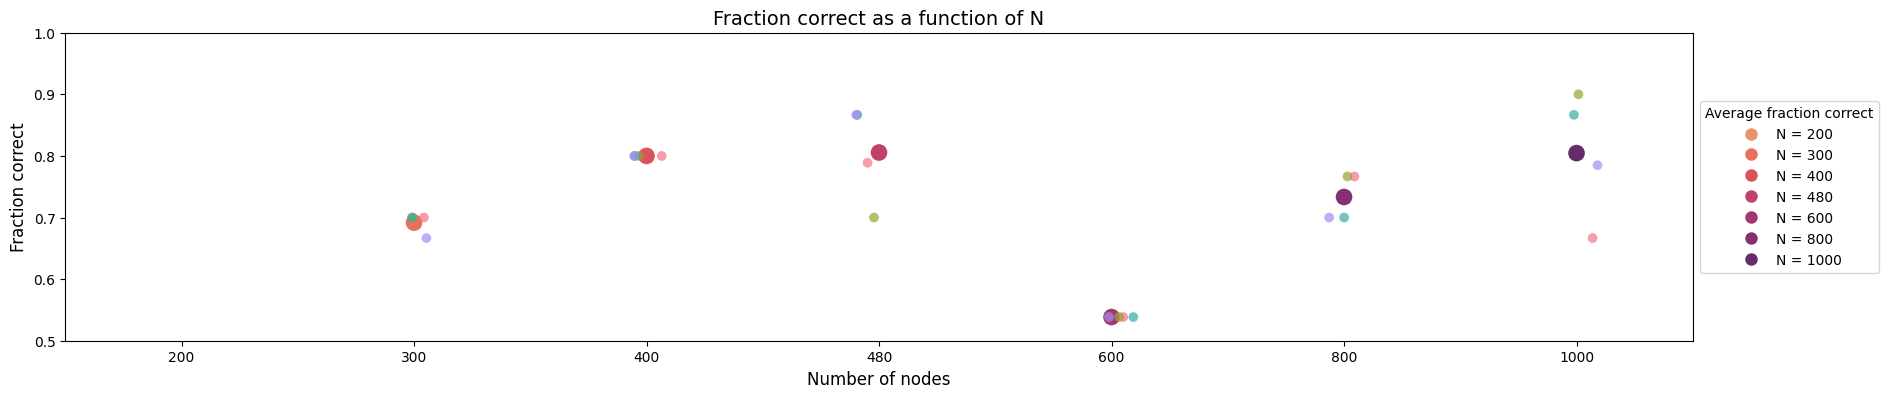

|Completed generating boxplot.
|Calculating fitted parameters...


C:\Users\danie\AppData\Local\Temp\ipykernel_30400\2237835773.py:379: OptimizeWarning: Covariance of the parameters could not be estimated
  fitted_params = curve_fit(sigmoid, current_subject_data['K'], current_subject_data['fc'], p0=(70, 20))[0]


,subject_number,N,K0,Delta
0,1,200,48.535613,4.361429
0,2,200,48.535613,4.361429
0,3,200,48.535613,4.361429
0,4,200,48.535613,4.361429
0,1,300,49.080939,10.730540
0,2,300,49.080939,10.730540
0,3,300,49.080939,10.730540
0,4,300,85.468578,83.166765
0,1,400,56.687442,0.851052
0,2,400,56.687442,0.851052


|Completed calculating fitted parameters.
|Generating psychometric curves...


C:\Users\danie\AppData\Local\Temp\ipykernel_30400\2237835773.py:464: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


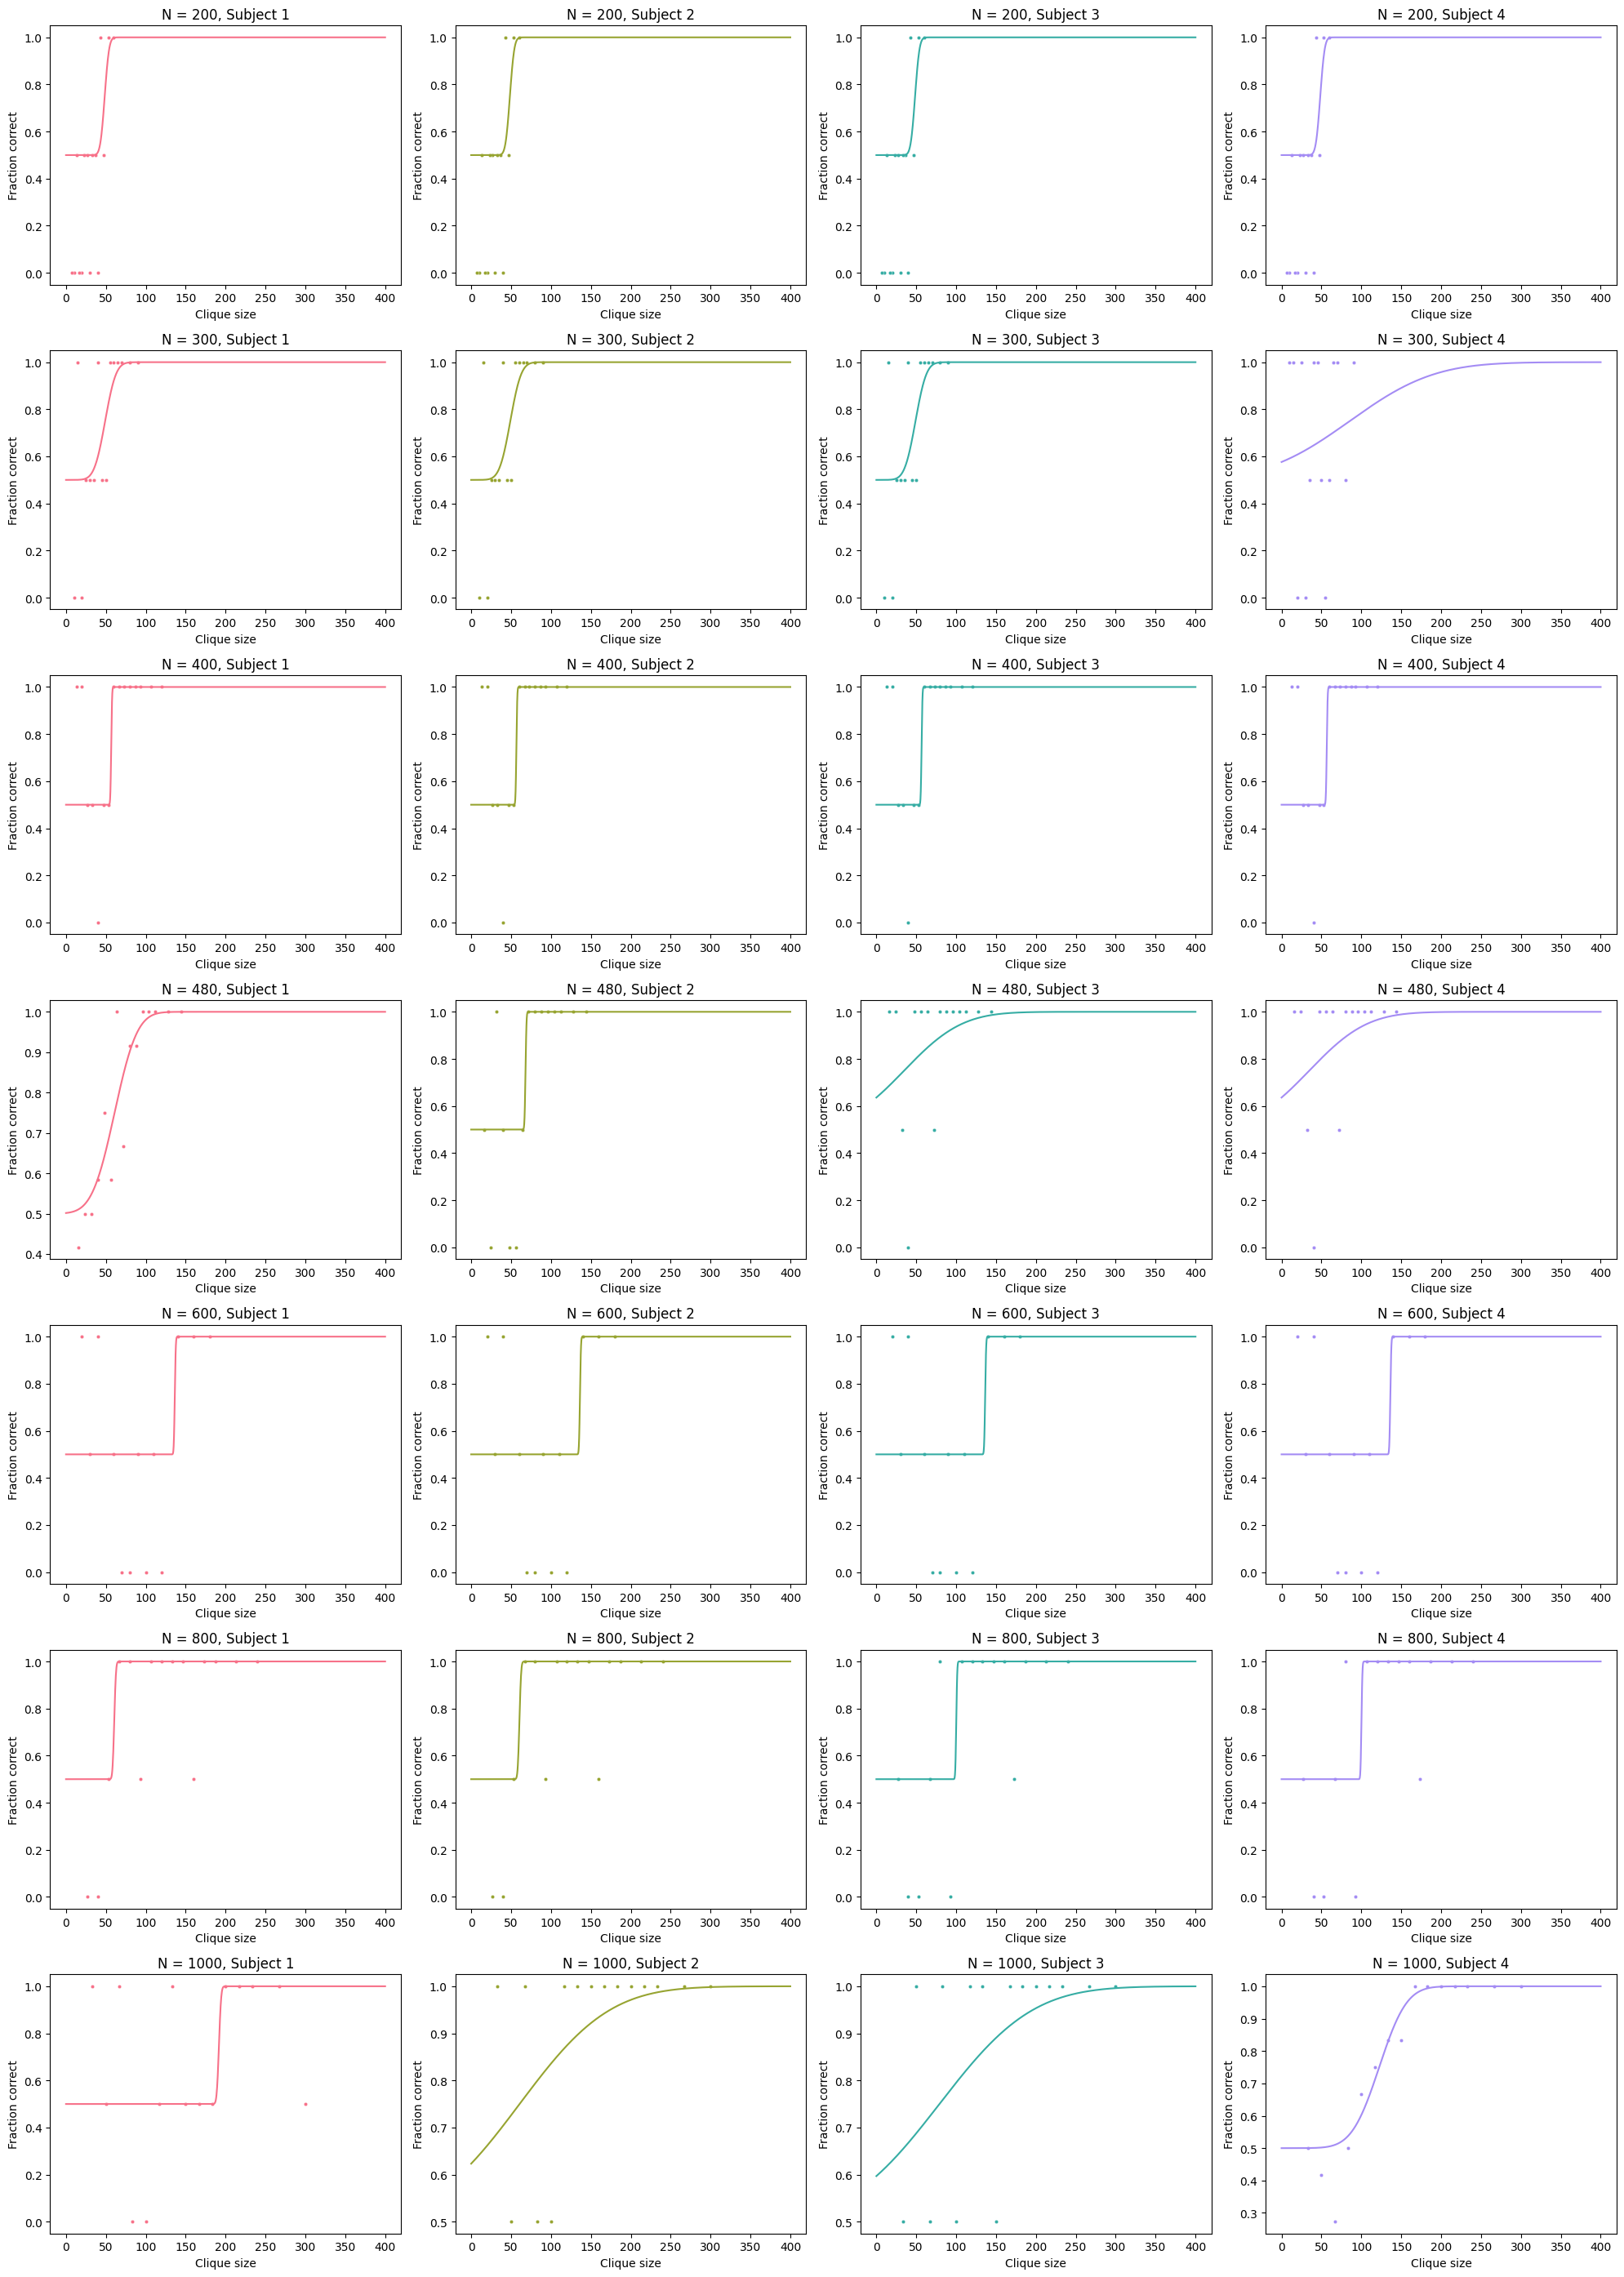

|Completed generating psychometric curves.
|Calculating shuffles dataframe...
Number of trials per clique size in the whole exp: 2


,subject_number,N,K,mean_shuffles,K/N
0,1,200,60.0,1.5,0.300
0,2,200,60.0,1.5,0.300
0,3,200,60.0,1.5,0.300
0,4,200,60.0,1.5,0.300
0,1,200,53.0,1.5,0.265
...,...,...,...,...,...
0,4,1000,50.0,0.0,0.050
0,1,1000,33.0,0.0,0.033
0,2,1000,33.0,0.0,0.033
0,3,1000,33.0,0.0,0.033


|Completed calculating shuffles dataframe.
|Generating shuffles graphs...
Mean K0 value for N = 200: 48.53561271560599
Mean K0 value for N = 300: 58.17784915124577
Mean K0 value for N = 400: 56.68744224620092
Mean K0 value for N = 480: 49.60394715721078
Mean K0 value for N = 600: 136.35341389114515
Mean K0 value for N = 800: 80.33431693930079
Mean K0 value for N = 1000: 113.457448718131


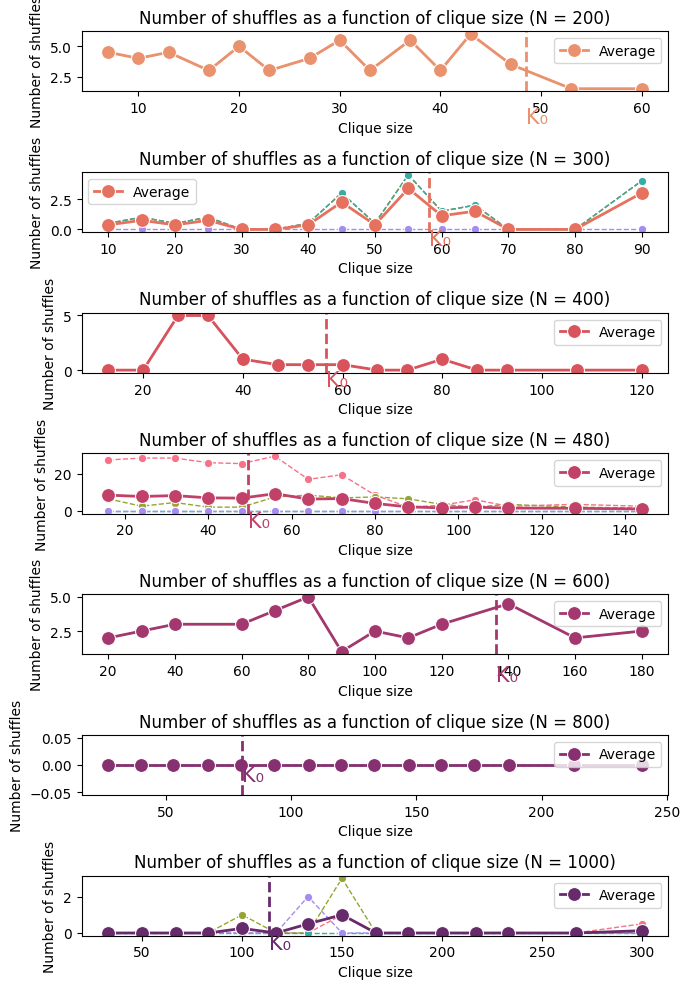

|Calculating shuffles stats...
Calculating shuffles stats for N = 200
Spearman correlation coefficient for N = 200: -0.3219064416801655
P-value for N = 200: 0.006067795812016848
Calculating shuffles stats for N = 300
Spearman correlation coefficient for N = 300: 0.07609559603218746
P-value for N = 300: 0.7183252406911097
Calculating shuffles stats for N = 400
Spearman correlation coefficient for N = 400: -0.4151802259992524
P-value for N = 400: 0.0004858850968544304
Calculating shuffles stats for N = 480
Spearman correlation coefficient for N = 480: -0.1437749402513262
P-value for N = 480: 0.13654933635292912
Calculating shuffles stats for N = 600
Spearman correlation coefficient for N = 600: -0.044699015626767424
P-value for N = 600: 0.37651332772937984
Calculating shuffles stats for N = 800
Spearman correlation coefficient for N = 800: nan
P-value for N = 800: nan
Calculating shuffles stats for N = 1000
Spearman correlation coefficient for N = 1000: 0.03555010810201558
P-value for N 

C:\Users\danie\AppData\Local\Temp\ipykernel_30400\2237835773.py:626: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  shuffles_stat = spearmanr(currentN_shuffles['mean_shuffles'], currentN_shuffles['K'], alternative='less')


,N,correlation,p-value
0,200,-0.321906,0.006068
0,300,0.076096,0.718325
0,400,-0.415180,0.000486
0,480,-0.143775,0.136549
0,600,-0.044699,0.376513
0,800,NaN,NaN
0,1000,0.035550,0.606290


|Completed calculating shuffles stats.
|Calculating response times dataframe...


,subject_number,N,K,mean_resp_time,K/N
0,1,200,60.0,1.891400,0.300
0,2,200,60.0,1.891400,0.300
0,3,200,60.0,1.891400,0.300
0,4,200,60.0,1.891400,0.300
0,1,200,53.0,0.988000,0.265
...,...,...,...,...,...
0,4,1000,50.0,1.072333,0.050
0,1,1000,33.0,0.117500,0.033
0,2,1000,33.0,0.263500,0.033
0,3,1000,33.0,0.602000,0.033


|Completed calculating response times dataframe.
|Generating response times graphs...


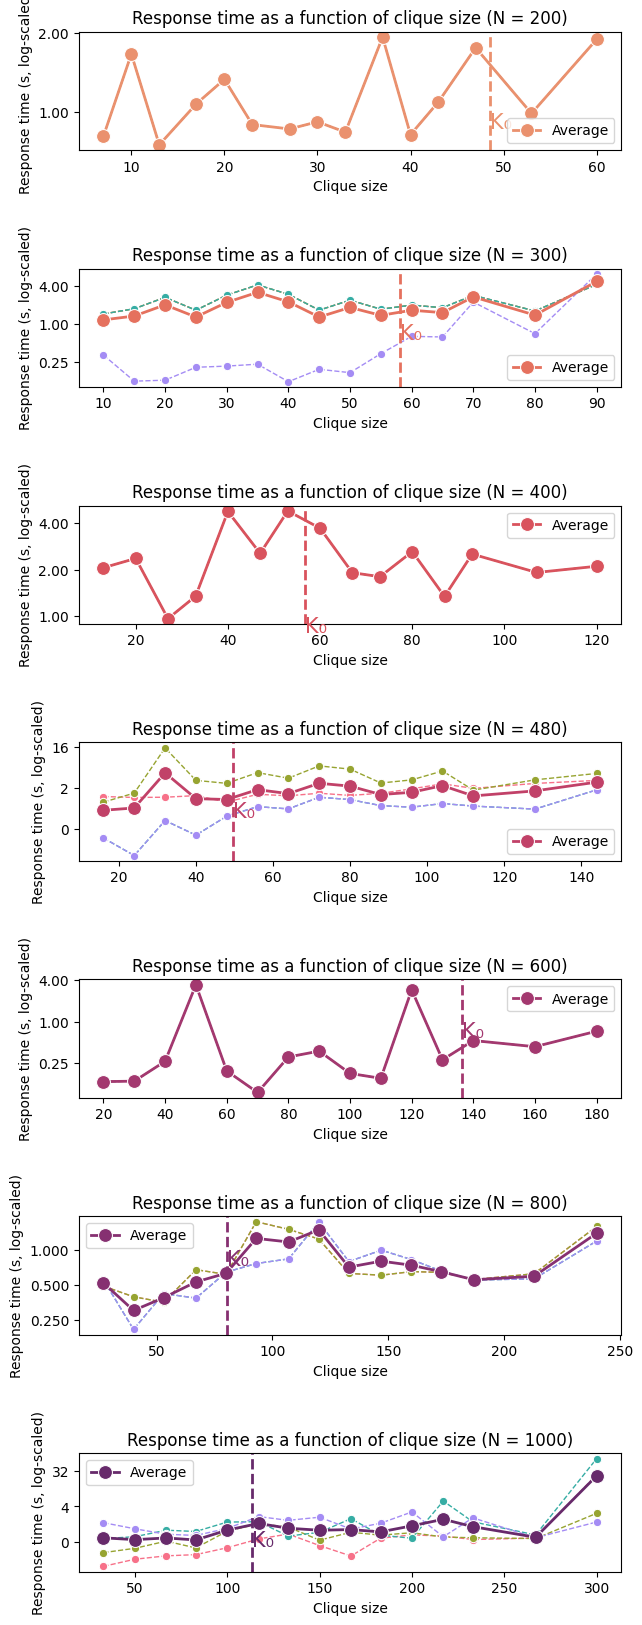

|Completed generating response times graphs.
|Calculating response times stats...
Calculating response time stats for N = 200
Mean response times for smallest K value: 0.8092727272727273 +- 0.0
Mean response times for closest K value: 1.7582222222222221 +- 0.0
Shapiro-Wilk test for normality:
- for smallest K value: ShapiroResult(statistic=np.float64(1.0), pvalue=np.float64(1.0))
- for closest K value: ShapiroResult(statistic=np.float64(1.0), pvalue=np.float64(1.0))
t-test for N = 200: TtestResult(statistic=np.float64(inf), pvalue=np.float64(0.0), df=np.int64(3))
Calculating response time stats for N = 300
Mean response times for smallest K value: 1.15 +- 0.2763333333333333
Mean response times for closest K value: 1.6324750000000001 +- 0.33332500000000004
Shapiro-Wilk test for normality:
- for smallest K value: ShapiroResult(statistic=np.float64(0.629776264554299), pvalue=np.float64(0.0012407259151036277))
- for closest K value: ShapiroResult(statistic=np.float64(0.629776264554299), pv

c:\Users\danie\Desktop\HUPLACLIP-analysis\.venv-analysis\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\danie\Desktop\HUPLACLIP-analysis\.venv-analysis\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return hypotest_fun_in(*args, **kwds)


,N,t-statistic,p-value
0,200,inf,0.000000
0,300,8.465711,0.001730
0,400,inf,0.000000
0,480,1.199212,0.158263
0,600,inf,0.000000
0,800,10.368578,0.000957
0,1000,5.130181,0.007172


|Completed calculating response times stats.
|Calculating visual strategy dataframe...


,subject_number,N,K,clustering_score,correct
827,4,1000,300.0,0.003049,True
828,4,1000,300.0,0.002978,True
829,4,1000,300.0,0.002935,True
830,4,1000,300.0,0.002895,True
831,4,1000,300.0,0.002946,True
...,...,...,...,...,...
1082,4,1000,33.0,0.003178,False
1083,4,1000,33.0,0.002802,True
1084,4,1000,33.0,0.003011,False
1085,4,1000,33.0,0.002597,True


|Completed calculating visual strategy dataframe.
|Generating visual strategy graphs...


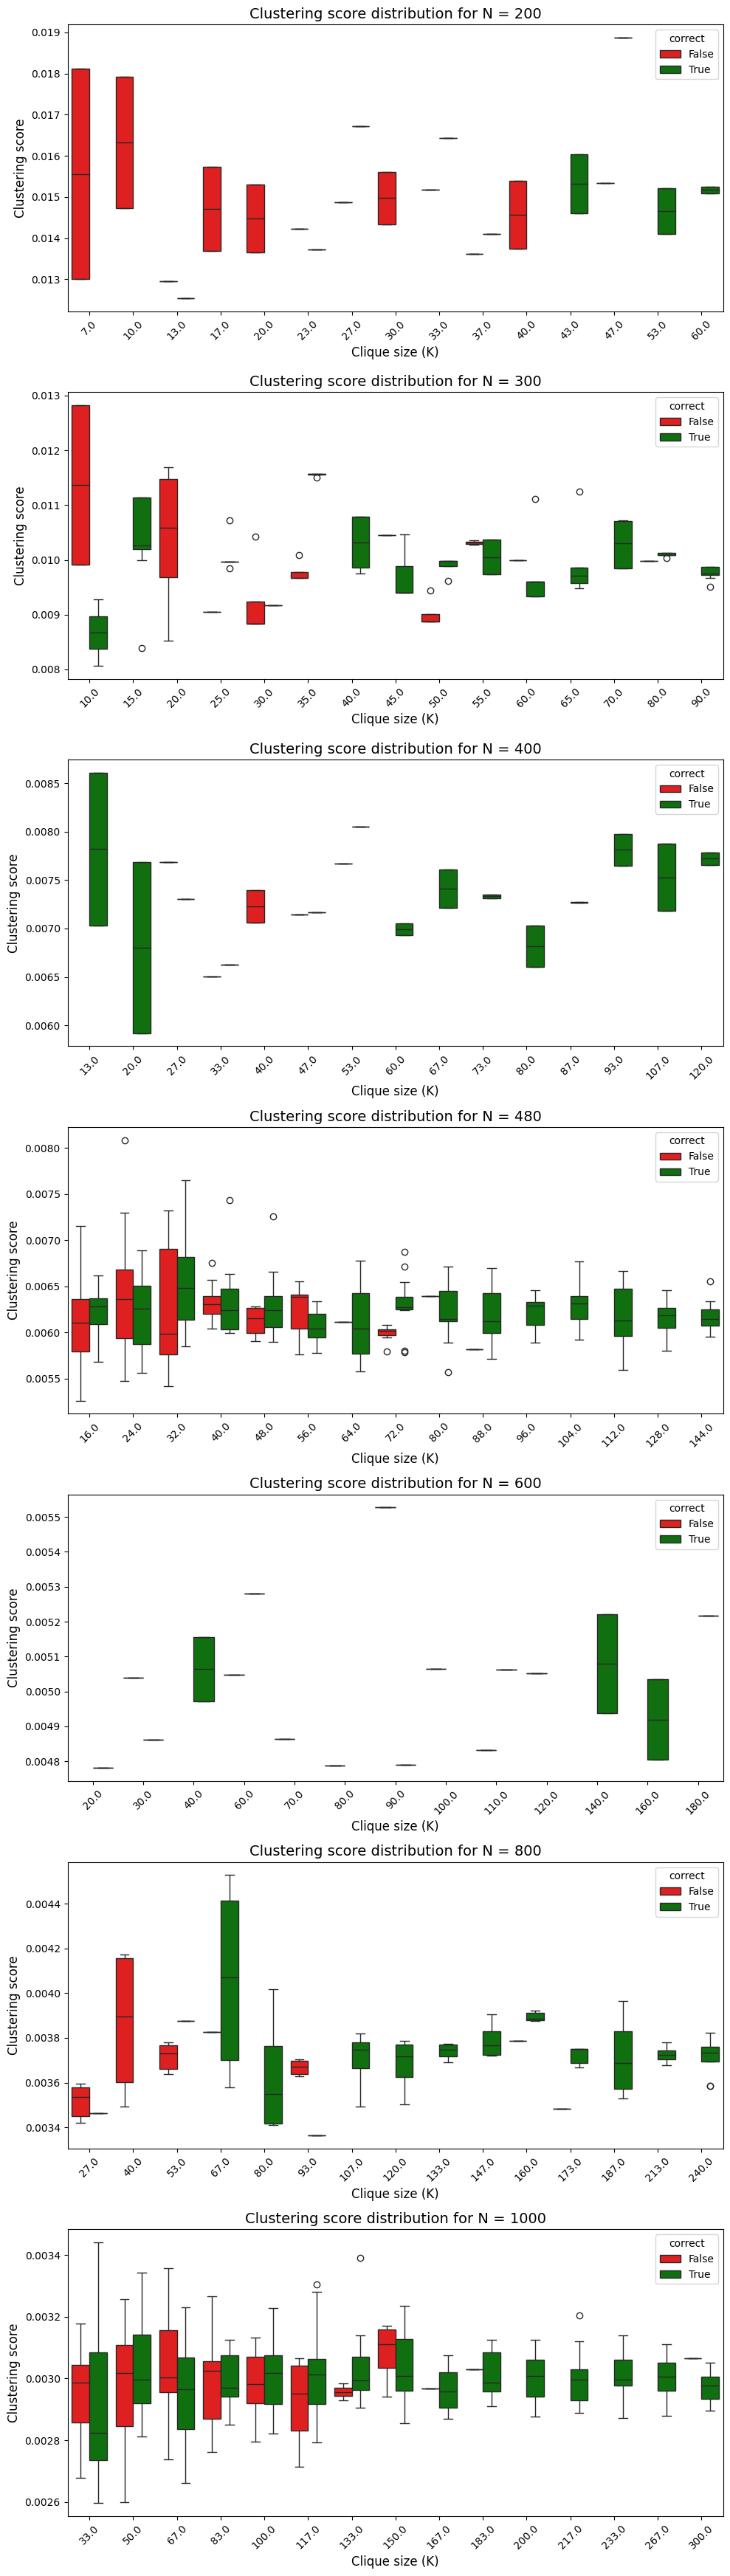

|Completed generating visual strategy graphs.
|Generating main plot...


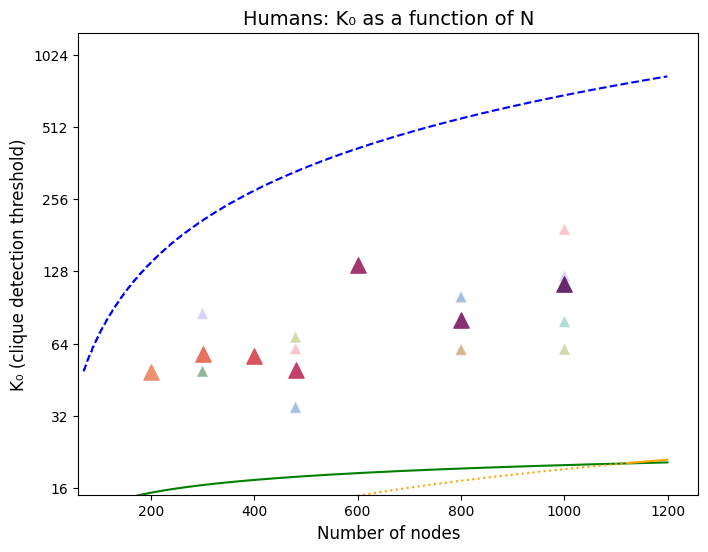

|Completed generating main plot.


In [41]:
# Instantiate the pipeline with the experiment name
human_pipeline = HumanAnalysisPipeline(experiment_name="2025-02_mini-pilot_browser-check", analysis_type="subject-wise", log_scale_K0=True, variance_test=True)

# Run the entire pipeline
human_pipeline.complete_human_pipeline()

# Machines:

For this code to work, the 'data/machines' folder needs to contain one sub-folder for each full experiment at one value of N. Each of these folders needs to have the N value as name (ex. '150', '400'...) and must contain the one folder for each model in 'model_names'.
The two csv files indicate, for each model:
- the fraction of correct responses for each tested K value;
- and testing metrics.

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
from scipy.special import ndtr
from scipy.optimize import curve_fit, differential_evolution
from matplotlib import ticker
from math import sqrt
from math import log, e
import sys
import os

## Pipeline:

In [55]:
class MachinesAnalysisPipeline:

    def __init__(self, experiment_name, variance_test=False, log_scale_K0=False):
        self.experiment_name = experiment_name
        self.variance_test = variance_test
        self.log_scale_K0 = log_scale_K0

        # Listing models in experiment and defining palette
        if self.experiment_name == "2025-03-06_CNS-abstract":
            # in this case, not necessary to keep consistency with previous visualizations
            model_names_palette = ['MLP', 'ViTscratch', 'ViTpretrained', 'CNN']
            # defining custom palette:
            machines_palette = {
                'MLP': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[0],
                'ViTscratch': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[1],
                'ViTpretrained': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[2],
                # skipping the color for 'Variance_test' as it is not considered as a model
                'CNN': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[4]
            }
        elif self.experiment_name == "2025-04_old-new-pipeline_num-params":
            model_names_palette = ['MLP-new-pipeline', 'ViTscratch-old-pipeline', 'ViTpretrained-old-pipeline', 'CNN_large-old-pipeline', 'MLP-old-pipeline', 'ViTscratch-new-pipeline', 'ViTpretrained-new-pipeline', 'CNN_large-new-pipeline']   # ADD MODEL NAMES HERE AND IN PALETTE BELOW
            # defining custom palette:
            machines_palette = {
                'MLP-new-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[0],
                'ViTscratch-old-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[1],
                'ViTpretrained-old-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[2],
                # skipping the color for 'Variance_test' as it is not considered as a model
                'CNN_large-old-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[4],
                'MLP-old-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[5],
                'ViTscratch-new-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[6],
                'ViTpretrained-new-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[7],
                'CNN_large-new-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette)+1)[8],
            }
        else:

            raise NotImplementedError(f"Experiment {self.experiment_name} not adapted yet. Please adapt the folders before running the pipeline.")

            model_names_palette = ['MLP', 'ViTscratch', 'ViTpretrained', 'Variance_test', 'CNN', 'MLP_7layers', 'MLP_10layers', 'MLP_20layers', 'MLP_lr1e-5', 'MLP_lr1e-5_10000steps', 'MLP_li-earlystop-scatter']   # ADD MODEL NAMES HERE AND IN PALETTE BELOW
            # defining custom palette:
            machines_palette = {
                'MLP_old-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette))[0],
                'ViTscratch': sns.color_palette(cc.glasbey, len(model_names_palette))[1],
                'ViTpretrained': sns.color_palette(cc.glasbey, len(model_names_palette))[2],
                'Variance_test': sns.color_palette(cc.glasbey, len(model_names_palette))[3],
                'CNN': sns.color_palette(cc.glasbey, len(model_names_palette))[4],
                'MLP_7layers': sns.color_palette(cc.glasbey, len(model_names_palette))[5],
                'MLP_10layers': sns.color_palette(cc.glasbey, len(model_names_palette))[6],
                'MLP_20layers': sns.color_palette(cc.glasbey, len(model_names_palette))[7],
                'MLP_lr1e-5': sns.color_palette(cc.glasbey, len(model_names_palette))[8],
                'MLP_lr1e-5_10000steps': sns.color_palette(cc.glasbey, len(model_names_palette))[9],
                'MLP_li-earlystop-scatter': sns.color_palette(cc.glasbey, len(model_names_palette))[10]
            }

        # Checking presence of 'fraction_correct' and 'metrics' csv files in folders:
        # - defining the path to the experiment folder:
        folder_path = os.path.join('data', 'machines', self.experiment_name)
        # - loop over all folders in the experiment folder (each folder corresponds to an N value)
        folders_N_values = []
        folders_model_names = []
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                folders_N_values.append(folder_name)
                # - loop over all folders in the N folder and define list of model names:
                for model_name in os.listdir(os.path.join(folder_path, folder_name)):
                    if os.path.isdir(os.path.join(folder_path, folder_name, model_name)):
                        folders_model_names.append(model_name)
                        # Define paths for the two required files
                        file_path_metrics = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_metrics.csv')
                        file_path_fraction_correct = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_fraction_correct.csv')

                        # Check for the presence of the metrics file
                        if not os.path.isfile(file_path_metrics):
                            raise FileNotFoundError(f"File {file_path_metrics} does not exist. Make sure to add the metrics file in all folders.")

                        # Check for the presence of the fraction_correct file
                        if not os.path.isfile(file_path_fraction_correct):
                            raise FileNotFoundError(f"File {file_path_fraction_correct} does not exist. Make sure to add the fraction correct file in all folders.")
                    else:
                        print(f"Folder {model_name} is not a directory.")
            else:
                print(f"Folder {folder_name} is not a directory.")
        # Removing duplicate N values and model names:
        folders_N_values = list(set(folders_N_values))
        folders_model_names = list(set(folders_model_names))

        # checking that all model names in the folders are present in the palette:
        if not all(elem in model_names_palette for elem in folders_model_names):
            raise ValueError(f"Model names in folders do not match the model names in the palette. Make sure to add all model names in the palette.")

        # Store list of N values in the current experiment (used to loop through all N values)
        self.N_values = [int(N_value) for N_value in folders_N_values]
        print(f"Found N values: {self.N_values}")   
        self.machines_palette = machines_palette


    def retrieve_fraction_correct(self):
        print("|Retrieving fraction correct...")

        # defining the path to the experiment folder:
        folder_path = os.path.join('data', 'machines', self.experiment_name)
        df_machines_fraction_correct = pd.DataFrame()

        # loop over all folders in the experiment folder (each folder corresponds to an N value)
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                # loop over all folders in the N folder (each folder corresponds to a model)
                for model_name in os.listdir(os.path.join(folder_path, folder_name)):
                    if os.path.isdir(os.path.join(folder_path, folder_name, model_name)):
                        file_path = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_fraction_correct.csv')
                        if os.path.isfile(file_path):
                            df_fraction_correct = pd.read_csv(file_path)
                            df_fraction_correct['model'] = model_name
                            df_fraction_correct['N'] = folder_name
                            df_machines_fraction_correct = pd.concat([df_machines_fraction_correct, df_fraction_correct], ignore_index=True)
                        else:
                            raise FileNotFoundError(f"File {file_path} does not exist.")
                    else:
                        print(f"Folder {model_name} is not a directory.")
            else:
                print(f"Folder {folder_name} is not a directory.")

        # converting the 'N' column to integer type:
        df_machines_fraction_correct['N'] = df_machines_fraction_correct['N'].astype(int)
        self.df_machines_fraction_correct = df_machines_fraction_correct

        # visualizing dataframe:
        display(df_machines_fraction_correct)
        print("|Completed retrieving fraction correct.")


    def calculate_fitted_params(self):
        print("|Calculating fitted parameters...")

        def sigmoid(k, k0, delta):
            return (1+ndtr((k-k0)/delta))/2

        # empty dataframe where fitted parameters will be stored:
        df_machines_fitted_params_appended = []

        # looping through all N values:
        for N_value in sorted(self.N_values):
            # selecting trials for current N value:
            current_data = self.df_machines_fraction_correct[self.df_machines_fraction_correct['N']==N_value]
            # looping through all models for current N value:
            for model in current_data['model'].unique():
                # accessing data for current subject:
                current_model_data = current_data[current_data['model'] == model]
                # calculating fitted parameters:
                fitted_params = curve_fit(sigmoid, current_model_data['clique size'], current_model_data['fraction correct'], p0=(70, 20))[0]
                # adding fitted parameters to the dataframe (including log-scaled K0):
                df_machines_fitted_params_appended.append(pd.DataFrame({'model':[model], 'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))

        # concatenating dataframe of fitted parameters:
        df_machines_fitted_params = pd.concat(df_machines_fitted_params_appended)
        # saving dataframe:
        self.df_machines_fitted_params = df_machines_fitted_params

        # visualizing dataframe:
        display(df_machines_fitted_params)
        print("|Completed calculating fitted parameters.")


    def metrics_summary(self):
        print("|Generating metrics summary...")

        # defining the path to the experiment folder:
        folder_path = os.path.join('data', 'machines', self.experiment_name)
        metrics_summary_df = pd.DataFrame()

        # loop over all folders in the experiment folder (each folder corresponds to an N value)
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                # loop over all folders in the N folder (each folder corresponds to a model)
                for model_name in os.listdir(os.path.join(folder_path, folder_name)):
                    if os.path.isdir(os.path.join(folder_path, folder_name, model_name)):
                        file_path = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_metrics.csv')
                        if os.path.isfile(file_path):
                            df_metrics_model = pd.read_csv(file_path)
                            df_metrics_model['N'] = int(folder_name)
                            df_metrics_model['model'] = model_name
                            # adding K0 value to the dataframe:
                            df_metrics_model['K0'] = self.df_machines_fitted_params.loc[(self.df_machines_fitted_params['N'] == int(folder_name)) & (self.df_machines_fitted_params['model'] == model_name), 'K0'].values[0]
                            metrics_summary_df = pd.concat([metrics_summary_df, df_metrics_model], ignore_index=True)
                        else:
                            print(f"File {file_path} does not exist.")
                    else:
                        print(f"Folder {folder_name} is not a directory.")

        # write k0 column in decimal notation:
        metrics_summary_df['K0'] = metrics_summary_df['K0'].apply(lambda x: '{:.2f}'.format(x))
        # rounding all values to 2 decimal places:
        metrics_summary_df = metrics_summary_df.round(2)
        # writing 'total_params' column in millions, and indicating it in the column name:
        metrics_summary_df['total_params'] = metrics_summary_df['total_params'] / 1e6
        metrics_summary_df.rename(columns={'total_params': 'total_params (M)'}, inplace=True)
        
        # TODO: scale 'CNN-large' total_params by 2400? 
        
        # place the 'model', 'N', 'K0' columns at the beginning of the dataframe:
        cols = ['model', 'N', 'K0'] + [col for col in metrics_summary_df.columns if col not in ['model', 'N', 'K0']]
        metrics_summary_df = metrics_summary_df[cols]

        display(metrics_summary_df)
        self.metrics_summary_df = metrics_summary_df
        print("|Completed generating metrics summary.")


    def number_of_parameters_comparison_graph(self):
        print("|Generating number of parameters graphs...")
        
        # - create subplots based on the number of N values:
        n_values = len(self.N_values)
        if n_values == 9:
            rows = 3
            cols = 3
        else:
            raise ValueError(f"The number of N values should be 9, but is {n_values}. Check for errors in the code.")
        fig, ax = plt.subplots(rows, cols, figsize=(20, 15))

        # Ensure ax is always a 2D array for consistency
        ax = ax.flatten()

        # - loop through the N values:
        for i, N_value in enumerate(sorted(self.N_values)):
            # isolating data for current N value:
            current_data = self.metrics_summary_df[self.metrics_summary_df['N'] == N_value]
            # filtering the data to include only the models for which 'total_params' is available:
            current_data = current_data[current_data['total_params (M)'].notna()]
            # getting the names of the models to filter the palette:
            models_names = current_data['model'].unique()
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in models_names}

            # creating barplot based on metrics summary dataframe:
            sns.barplot(data=current_data, x='model', y='total_params (M)', ax=ax[i], palette=machines_palette_filtered, hue='model')

            # setting labels and title for the subplot:
            ax[i].set_ylabel("Number of parameters (Millions)")
            ax[i].set_xlabel("Model")
            ax[i].set_title(f"Number of parameters for N = {int(N_value)}")
            ax[i].tick_params(axis='x', rotation=30)
            ax[i].tick_params(axis='y')
            ax[i].set_title(f"N = {int(N_value)}")

        # Hide any unused subplots
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])

        # Give the plot a title
        fig.suptitle(f"Number of parameters for each model in {self.experiment_name}", fontsize=16)
        
        # Show the plot
        plt.tight_layout()
        
        # TODO: save plots after agreement

        # Save plot as high resolution svg:
        plt.savefig(f'./plots/machines/{self.experiment_name}/machines-num-params_{self.experiment_name}.svg', dpi=300, bbox_inches="tight")
        plt.savefig(f'./plots/machines/{self.experiment_name}/machines-num-params_{self.experiment_name}.png', dpi=300, bbox_inches="tight")

        plt.show()   
        
        print("|Completed generating number of parameters graphs.")     
        

    def generate_psychometrics(self):
        print("|Generating psychometric curves...")
        
        # - create subplots based on the number of N values:
        n_values = len(self.N_values)
        if n_values == 9:
            rows = 3
            cols = 3
        else:
            raise ValueError(f"The number of N values should be 9, but is {n_values}. Check for errors in the code.")
        fig, ax = plt.subplots(rows, cols, figsize=(20, 15))

        # Ensure ax is always a 2D array for consistency
        ax = ax.flatten()

        # - loop through the N values:
        for i, N_value in enumerate(sorted(self.N_values)):
            # isolating data for current N value:
            current_data = self.df_machines_fraction_correct[self.df_machines_fraction_correct['N'] == N_value]
            # filtering the data to include only the models for which k0 is smaller than N:
            current_data = current_data[current_data['clique size'] < int(N_value)]
            # getting the names of the models to filter the palette:
            models_names = current_data['model'].unique()
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in models_names}
            # defining x values:
            x_vals = np.linspace(0, 0.7 * int(N_value), 1000)

            # drawing scatterplot based on fraction correct dataframe:
            sns.scatterplot(data=current_data, x='clique size', y='fraction correct', ax=ax[i], s=10, hue='model', palette=machines_palette_filtered)
            # defining y values and plotting the psychometric curve:
            for model in models_names:
                k0 = self.df_machines_fitted_params[(self.df_machines_fitted_params['N'] == N_value) & (self.df_machines_fitted_params['model'] == model)]['K0'].values[0]
                delta = self.df_machines_fitted_params[(self.df_machines_fitted_params['N'] == N_value) & (self.df_machines_fitted_params['model'] == model)]['Delta'].values[0]
                y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                ax[i].plot(x_vals, y_vals, color=machines_palette_filtered[model], label=model)

            # setting labels and title for the subplot:
            ax[i].set_ylabel("Fraction correct")
            ax[i].set_xlabel("Clique size")
            ax[i].set_title(f"Psychometric curves for N = {int(N_value)}")
            ax[i].tick_params(axis='x')
            ax[i].tick_params(axis='y')
            ax[i].set_title(f"Best models in {self.experiment_name} for N = {int(N_value)}")

        # Hide any unused subplots
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])

        # Show the plot
        plt.tight_layout()

        # # Save plot as high resolution svg:
        plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}.svg', dpi=300, bbox_inches="tight")
        plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}.png', dpi=300, bbox_inches="tight")

        plt.show()

        print("|Completed generating psychometric curves.")


    def generate_k0_plots(self):
        print("|Generating K0 plot...")

        # - create subplots based on the number of N values:
        n_values = len(self.N_values)
        if n_values == 9:
            rows = 3
            cols = 3
        else:
            raise ValueError(f"The number of N values should be 9, but is {n_values}. Check for errors in the code.")
        fig, ax = plt.subplots(rows, cols, figsize=(18, 15))

        # Ensure ax is always a 2D array for consistency
        ax = ax.flatten()

        # - loop through the N values:
        for i, N_value in enumerate(sorted(self.N_values)):
            # isolating data for current N value:
            current_fitted_params = self.df_machines_fitted_params[self.df_machines_fitted_params['N'] == N_value]
            # filtering the data to keep only the models for which K0 is smaller than N:
            current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in current_fitted_params['model'].unique()}
            # drawing swarmplot based on fraction correct dataframe:

            # TODO: use relplot instead of swarmplot to also include "total_params" information
            
            sns.swarmplot(data=current_fitted_params, x='N', y='K0', hue='model', palette=machines_palette_filtered, ax=ax[i], s=7)

            # Draw the statistical limit line
            ax[i].axhline(y=2*np.log2(int(N_value)), color='g', linestyle=':')
            
            # TODO: ADD THE VARIANCE TEST LINE FOR 75% CORRECT (also in the legend)
            if self.variance_test:
                variance_algo = Variance_algo()
                ax[i].axhline(y=variance_algo.find_75correct(N_value), color='blue', linestyle='dashed')
              
            # Adjust legend to include the statistical limit line and variance test line
            handles, labels = ax[i].get_legend_handles_labels()
            # Append the statistical limit line handle and label
            handles.append(plt.Line2D([], [], color='g', linestyle=':', label='STAT limit'))
            if self.variance_test:
                handles.append(plt.Line2D([], [], color='blue', linestyle='dashed', label='Variance test (75% accuracy)'))
            # Append the variance test line handle and label if applicable
            labels.append('STAT limit')
            if self.variance_test:
                labels.append('Variance test (75% accuracy)')
            # Add the legend to the plot
            ax[i].legend(handles=handles, labels=labels)

            # Add axes labels to the plot
            ax[i].set_xlabel('Number of nodes', size=12)
            ax[i].set_ylabel('K₀', size=12)
            ax[i].set_title(f'Machines: K₀ as a function of N = {int(N_value)}', size=14)

        # Hide any unused subplots
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])

        # Show the plot
        plt.tight_layout()

        # Save plot as high resolution svg:
        plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}{"_Variance-test" if self.variance_test else ""}.svg', dpi=300, bbox_inches="tight")
        plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}{"_Variance-test" if self.variance_test else ""}.png', dpi=300, bbox_inches="tight")

        plt.show()

        print("|Completed generating K0 plot.")


    def generate_main_plot(self):
        print("|Generating main plot...")

        # Create a smaller figure with specified size
        fig, ax = plt.subplots(figsize=(8, 6))

        # Loop through the N values:
        for i, N_value in enumerate(sorted(self.N_values)):
            # Isolating data for the current N value:
            current_fitted_params = self.df_machines_fitted_params[self.df_machines_fitted_params['N'] == N_value]

            # Filtering the data to keep only the models for which K0 is smaller than N:
            current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in current_fitted_params['model'].unique()}

            # Add a small jitter to the N column to avoid overlap
            jittered_x = current_fitted_params['N'] + np.random.uniform(-10, 10, size=len(current_fitted_params))

            # Draw scatterplot with jittered x values (only drawing one legend)
            sns.scatterplot(data=current_fitted_params, x=jittered_x, y='K0', hue='model',
                            palette=machines_palette_filtered, legend=(N_value == 400 or N_value == 800), s=50, ax=ax)    # Only draw legend for N=400 (contains MLP variants)

        # THEORETICAL AND COMPUTATIONAL LIMITS:
        N = np.arange(0.1, 1200)
        K_it = 2 * np.log2(N)
        K_comp = np.sqrt(N / np.e)
        limits_palette = ['green', 'orange']
        ax.plot(N, K_it, label='STAT limit', color=limits_palette[0])
        ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
        ax.plot(N[1125:], K_comp[1125:], color=limits_palette[1])

        # Variance test:        
        if self.variance_test:
            N_range_variance_test = np.arange(70, 1200)
            variance_algo = Variance_algo()
            ax.plot(variance_algo.find_75correct(N_range_variance_test).keys(), variance_algo.find_75correct(N_range_variance_test).values(), label='Variance test (75% accuracy)', color='blue', linestyle='dashed')

        # Add axes labels to the plot
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel('K₀ (clique detection threshold)', size=12)

        if self.log_scale_K0:
            ax.set_yscale('log', base=2)
            ax.set_xlim(60, *ax.get_xlim()[1:])
            ax.set_ylim(15, *ax.get_ylim()[1:])
            # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        else:
            ax.autoscale()

        # Customize legend:
        handles, labels = ax.get_legend_handles_labels()
        filtered_handles = []
        filtered_labels = []
        seen_labels = set()

        # Filter out duplicate elements in the legend
        for handle, label in zip(handles, labels):
            if label not in seen_labels:
                filtered_handles.append(handle)
                filtered_labels.append(label)
                seen_labels.add(label)

        # Add a custom legend with only the desired elements
        ax.legend(filtered_handles, filtered_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Legend:')

        # Set title:
        ax.set_title('Machines: K₀ as a function of N', size=14)

        plt.grid()

        # Save plot as high resolution svg:
        plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}{"_Variance-test" if self.variance_test else ""}{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
        plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}{"_Variance-test" if self.variance_test else ""}{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")

        plt.show()

        print("|Completed generating main plot.")


    def fitted_params_machines(self):
        self.retrieve_fraction_correct()
        self.calculate_fitted_params()
        return self.df_machines_fitted_params, self.machines_palette

    def complete_machines_pipeline(self):
        self.retrieve_fraction_correct()
        self.calculate_fitted_params()
        self.metrics_summary()
        self.number_of_parameters_comparison_graph()
        self.generate_psychometrics()
        self.generate_k0_plots()
        self.generate_main_plot()

## Run pipeline:

Folder runs_reference.txt is not a directory.
Found N values: [100, 300, 150, 200, 1200, 400, 480, 600, 800]
|Retrieving fraction correct...
Folder runs_reference.txt is not a directory.


,clique size,fraction correct,model,N
0,70,0.99,CNN_large-old-pipeline,100
1,69,0.99,CNN_large-old-pipeline,100
2,68,0.99,CNN_large-old-pipeline,100
3,67,0.99,CNN_large-old-pipeline,100
4,66,0.98,CNN_large-old-pipeline,100
...,...,...,...,...
5285,23,0.49,ViTscratch-old-pipeline,800
5286,17,0.49,ViTscratch-old-pipeline,800
5287,12,0.50,ViTscratch-old-pipeline,800
5288,6,0.51,ViTscratch-old-pipeline,800


|Completed retrieving fraction correct.
|Calculating fitted parameters...


C:\Users\danie\AppData\Local\Temp\ipykernel_19580\1756075573.py:149: OptimizeWarning: Covariance of the parameters could not be estimated
  fitted_params = curve_fit(sigmoid, current_model_data['clique size'], current_model_data['fraction correct'], p0=(70, 20))[0]


,model,N,K0,Delta
0,CNN_large-old-pipeline,100,1.845103e+01,3.978695e+00
0,MLP-new-pipeline,100,2.199810e+01,4.322938e+00
0,MLP-old-pipeline,100,2.568927e+01,5.240386e+00
0,ViTpretrained-new-pipeline,100,1.731163e+01,4.000143e+00
0,ViTpretrained-old-pipeline,100,2.070365e+01,6.984122e+00
0,ViTscratch-new-pipeline,100,4.718305e+01,2.226734e+01
0,ViTscratch-old-pipeline,100,2.554924e+01,6.502993e+00
0,CNN_large-old-pipeline,150,2.430369e+01,4.969536e+00
0,MLP-new-pipeline,150,3.374975e+01,6.574728e+00
0,MLP-old-pipeline,150,3.859321e+01,7.498055e+00


|Completed calculating fitted parameters.
|Generating metrics summary...


,model,N,K0,TP,FP,TN,FN,precision,recall,F1,AUC_ROC,total_params (M)
0,CNN_large-old-pipeline,100,18.45,13572,398,17519,4351,0.97,0.76,0.85,0.90,445.065761
1,MLP-new-pipeline,100,22.00,12676,537,17346,5281,0.96,0.71,0.81,0.88,2.023824
2,MLP-old-pipeline,100,25.69,11790,444,17451,6155,0.96,0.66,0.78,0.87,NaN
3,ViTpretrained-new-pipeline,100,17.31,13904,939,16995,4002,0.94,0.78,0.85,0.90,85.385473
4,ViTpretrained-old-pipeline,100,20.70,13815,2384,15551,4090,0.85,0.77,0.81,0.87,NaN
5,ViTscratch-new-pipeline,100,47.18,11935,5828,12079,5998,0.67,0.67,0.67,0.73,85.385473
6,ViTscratch-old-pipeline,100,25.55,12211,1259,16683,5687,0.91,0.68,0.78,0.85,NaN
7,CNN_large-old-pipeline,1200,167.72,20550,65,25497,5088,1.00,0.80,0.89,0.93,445.065761
8,MLP-new-pipeline,1200,264.75,17714,231,25240,8015,0.99,0.69,0.81,0.88,288.023824
9,MLP-old-pipeline,1200,310.27,16103,137,25606,9354,0.99,0.63,0.77,0.87,NaN


|Completed generating metrics summary.
|Generating number of parameters graphs...


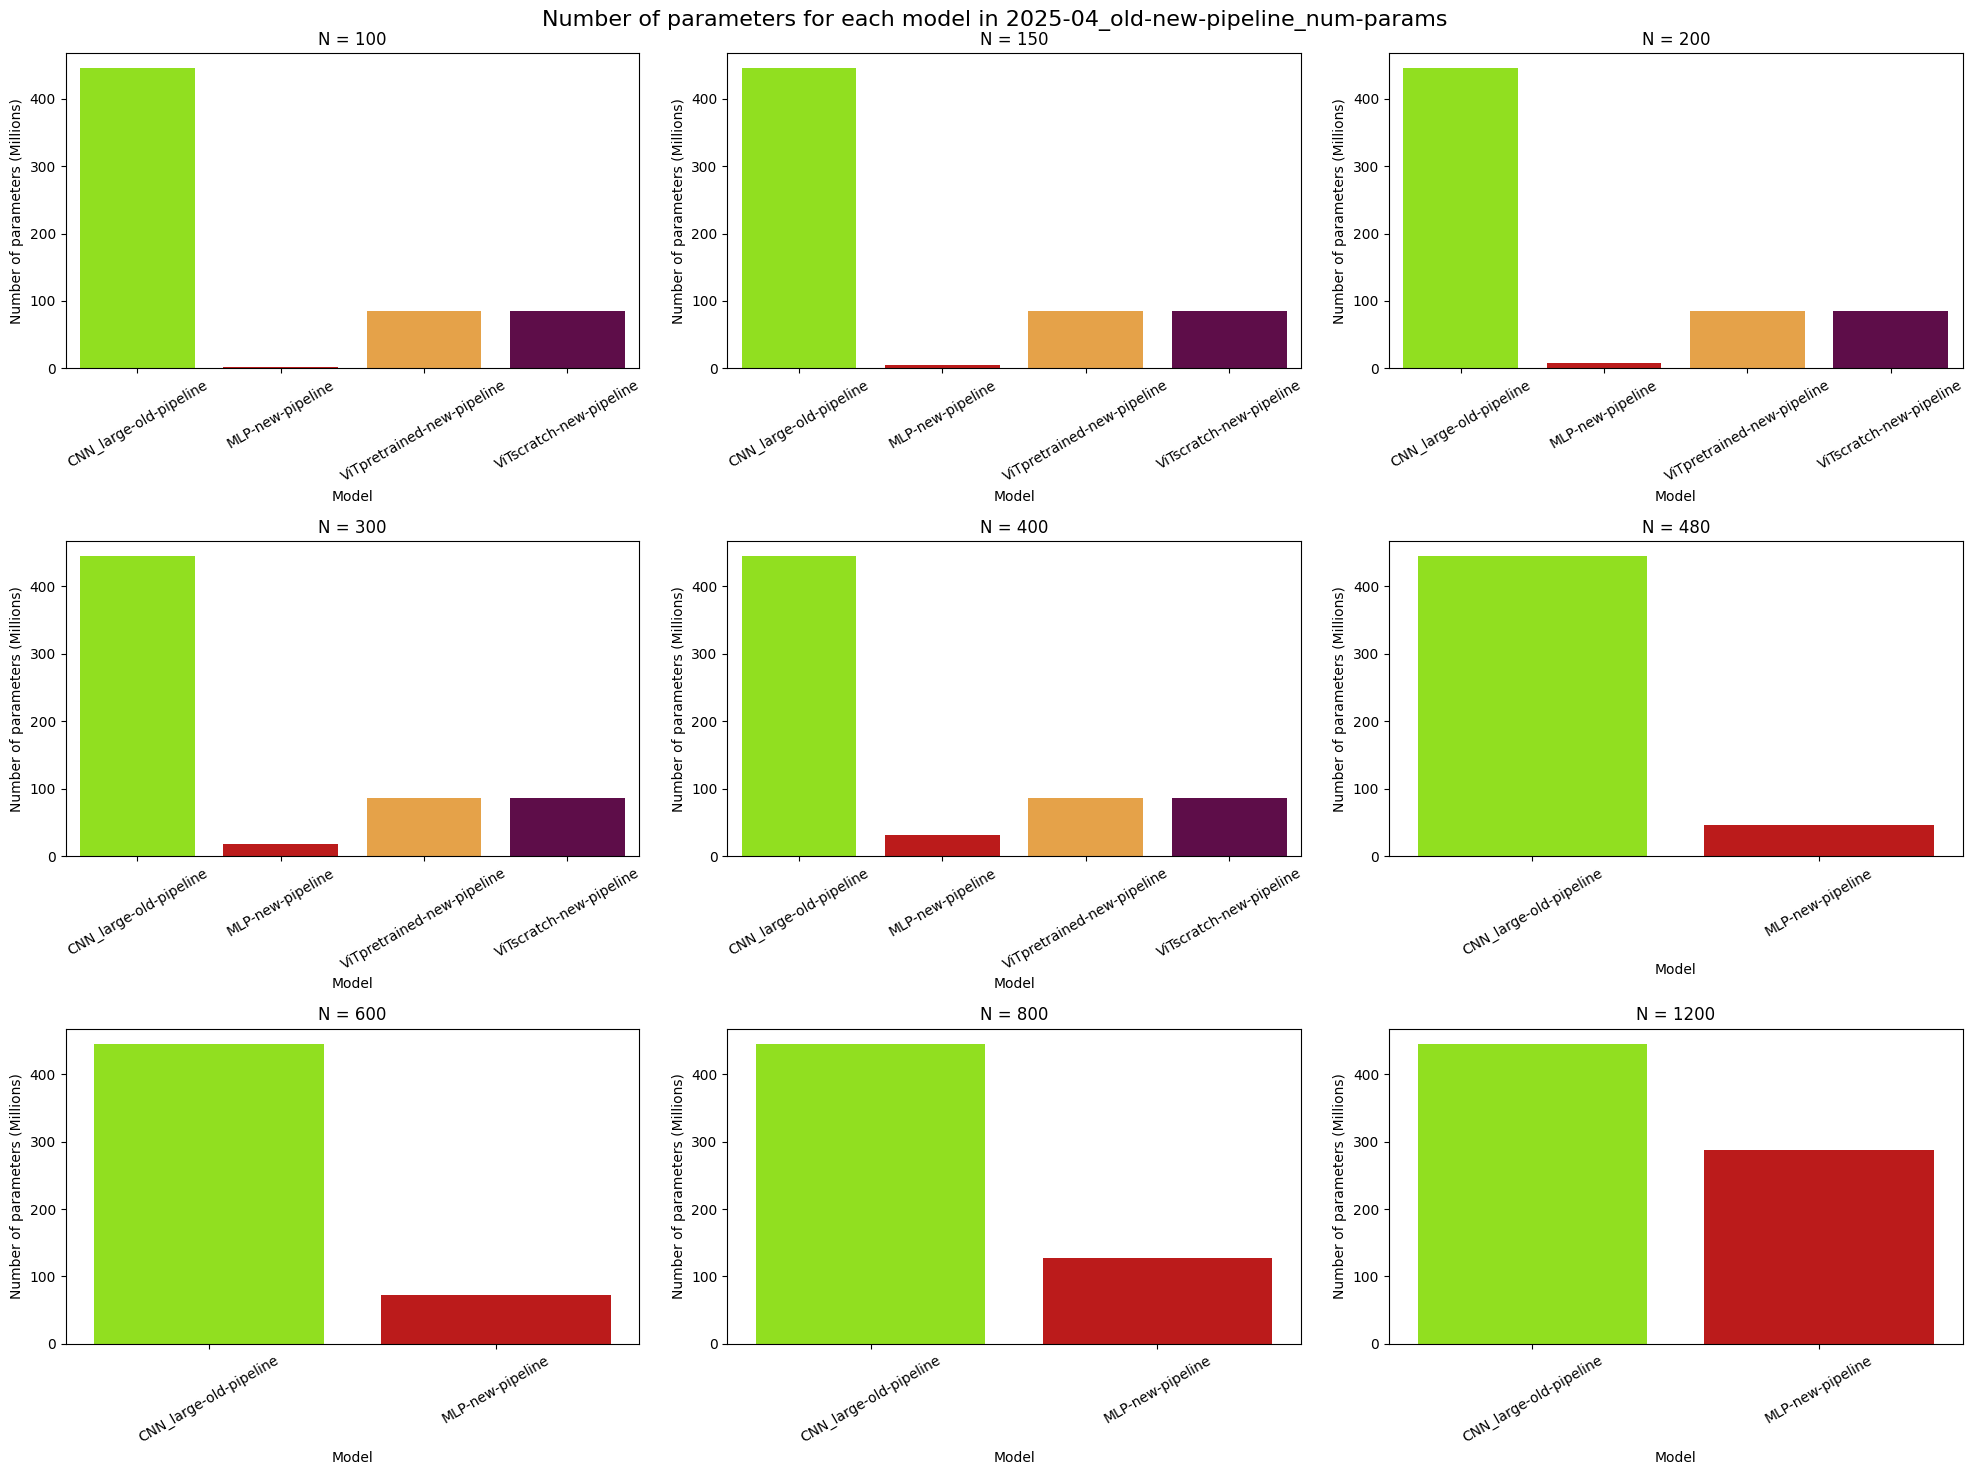

|Completed generating number of parameters graphs.
|Generating psychometric curves...


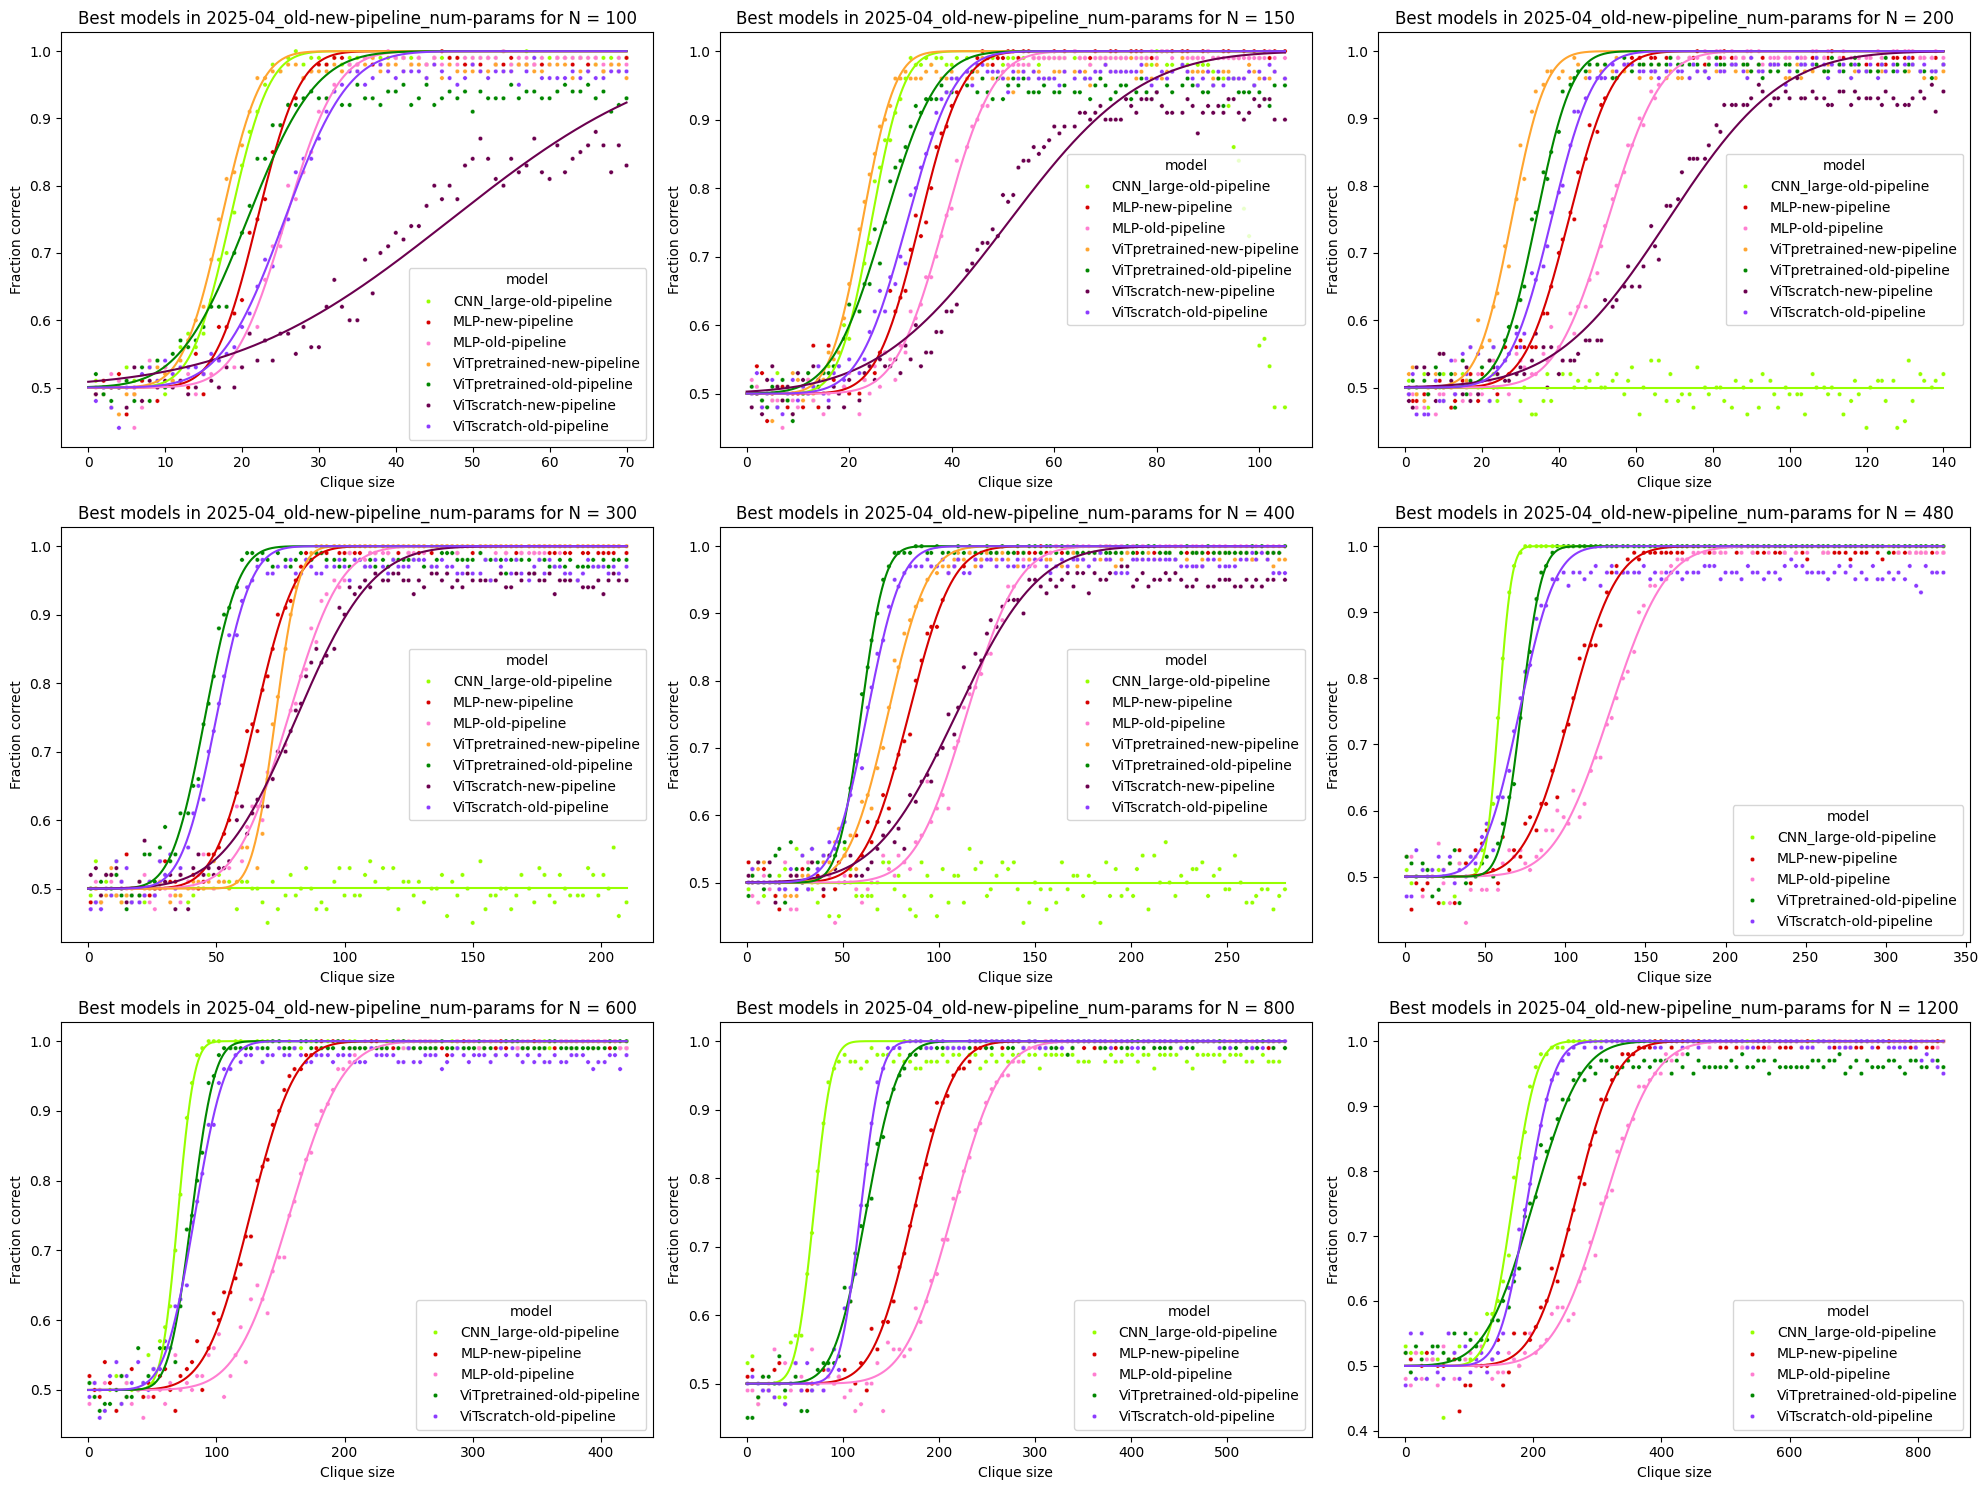

|Completed generating psychometric curves.
|Generating K0 plot...


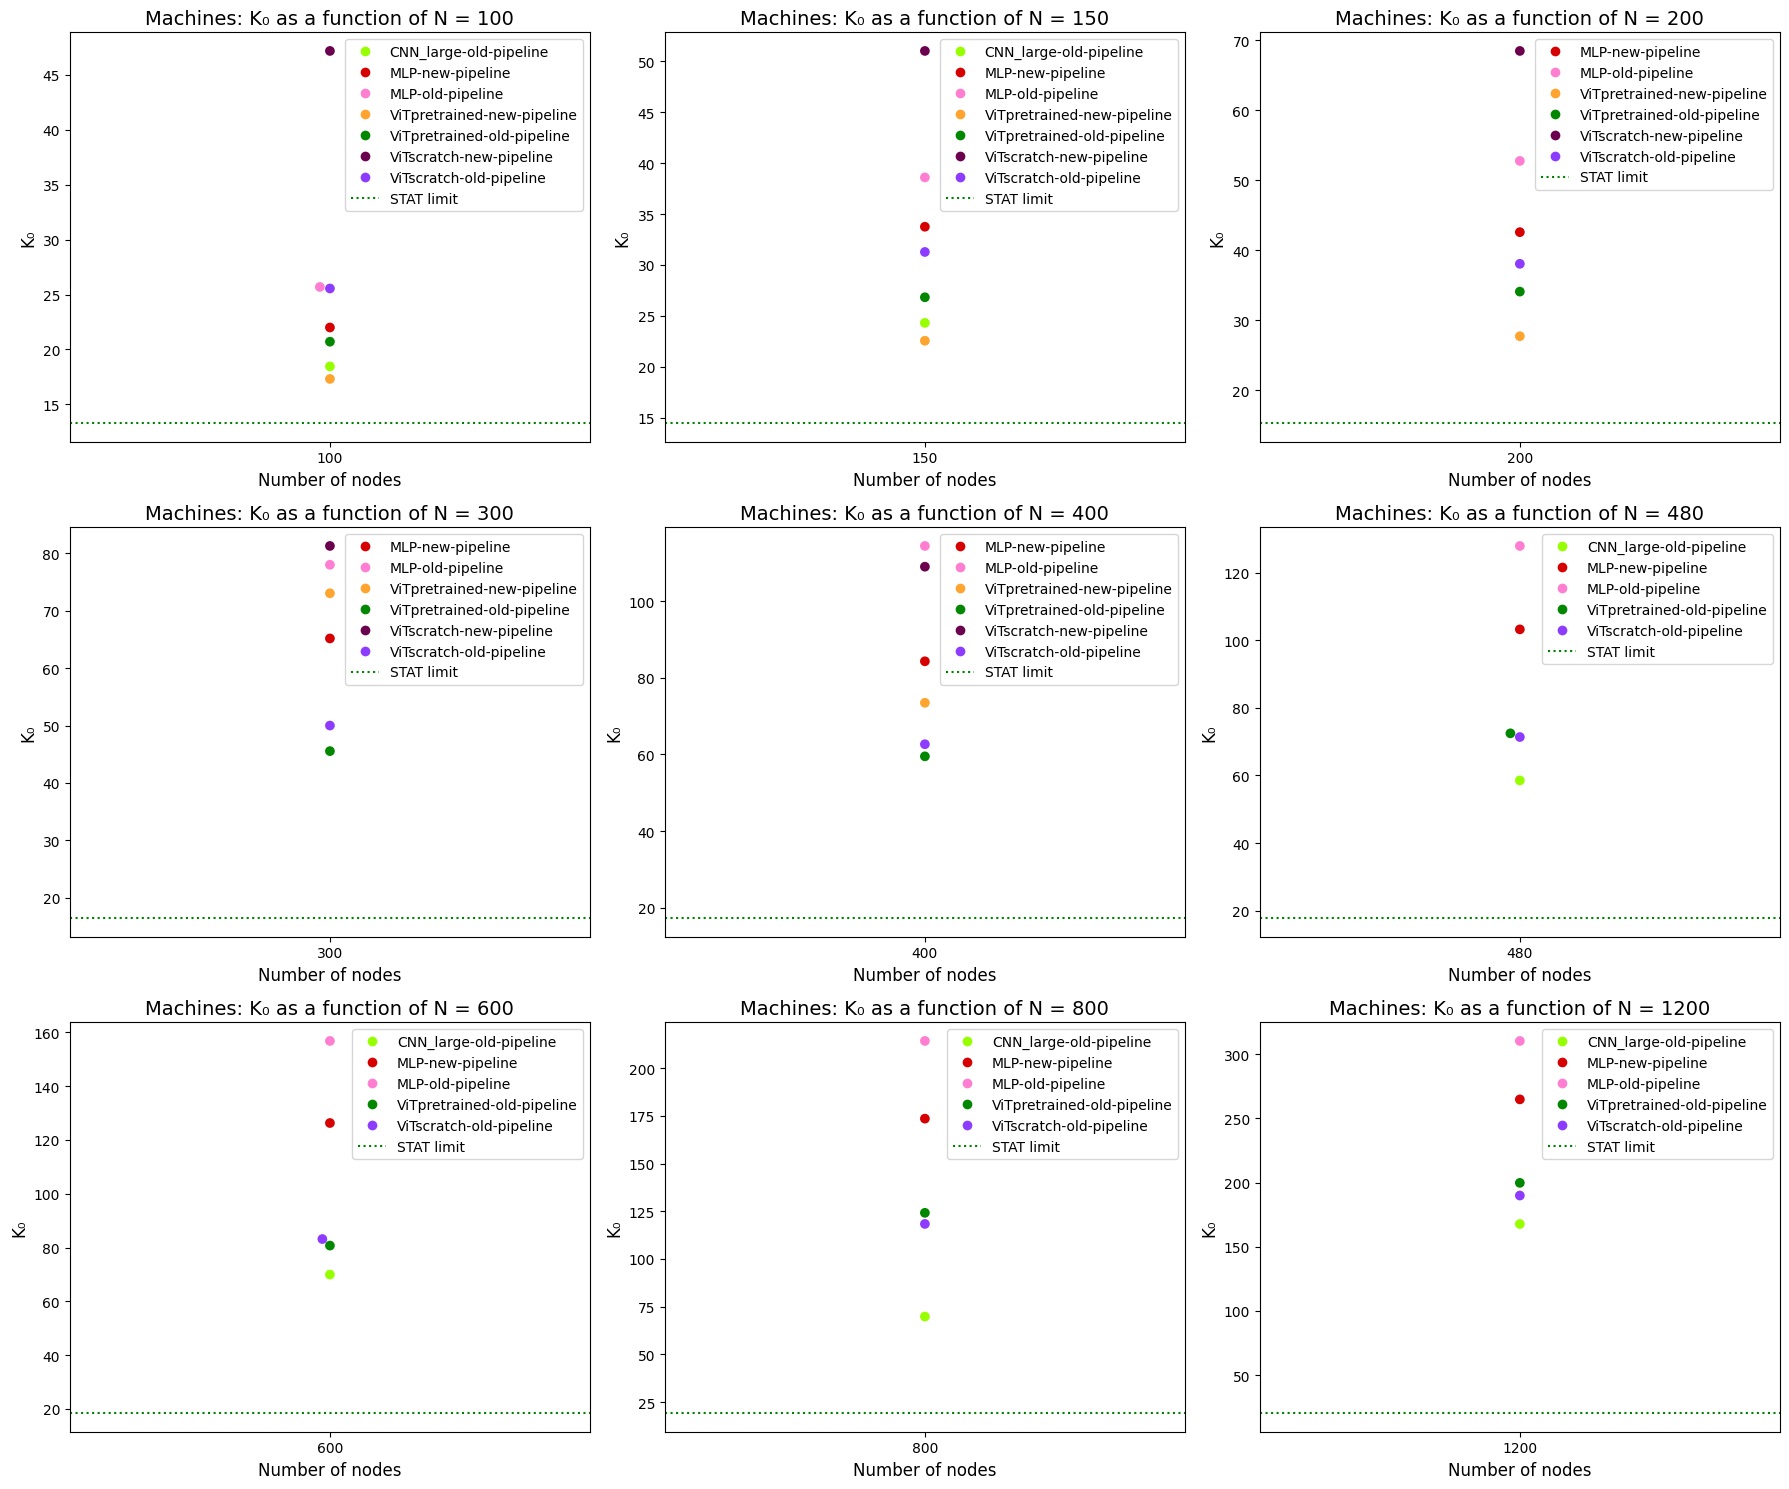

|Completed generating K0 plot.
|Generating main plot...


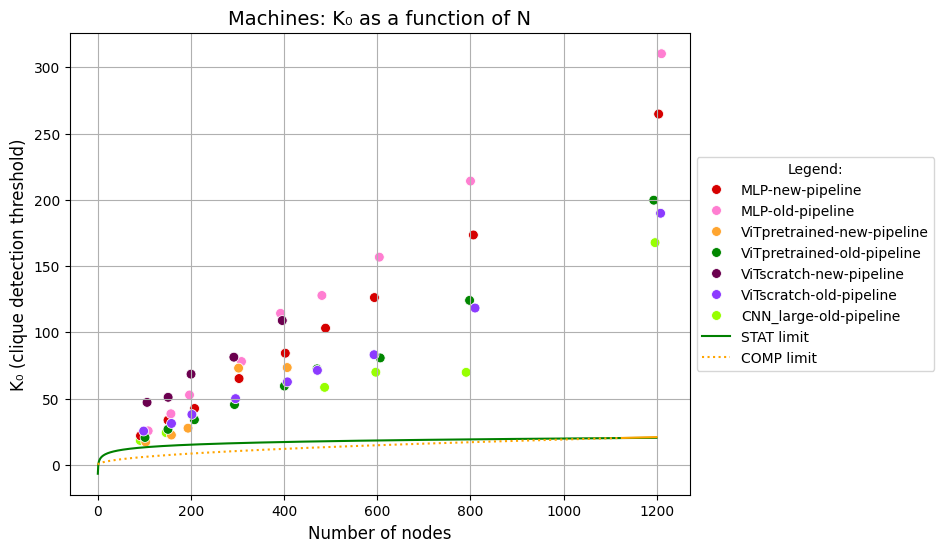

|Completed generating main plot.


In [57]:
# Instantiate the pipeline with the experiment name
exp_name = "2025-04_old-new-pipeline_num-params" # ADD EXPERIMENT NAME HERE
machines_pipeline = MachinesAnalysisPipeline(experiment_name=exp_name, variance_test=False, log_scale_K0=False)

# Run the entire pipeline
machines_pipeline.complete_machines_pipeline()

# Rudy's data:

This data has been given to us by Rudy, and is reported in the format he gave us at:

`C:\Users\danie\OneDrive - Università Campus Bio-Medico di Roma\Project-backup\HUPLACLIP - analysis\pilot_2_horizontal\Pilot2-combined-analysis.ipynb`

In [4]:
rudy_data = {
    "N": [300, 400, 500, 600, 700, 800, 900, 1000],
    "K0": [58.807378, 68.460279, 69.274007, 83.711061, 77.293921, 99.021618, 97.063763, 120.421003],
    "Delta": [33.296757, 32.858235, 25.201322, 32.531213, 27.540676, 43.135570, 32.509116, 58.510465],
}

# Create DataFrame
df_rudy_fitted_params = pd.DataFrame(rudy_data)

# Display the Dataframe:
df_rudy_fitted_params

In [5]:
from scipy.stats import linregress

# fitting linearly K0 as a function of N and storing slope and intercept:
slope, intercept, r_value, p_value, std_err = linregress(df_rudy_fitted_params['N'], df_rudy_fitted_params['K0'])

# Combined analyses:

In [ ]:
# Selecting data and calling the pipelines to calculate the fitted parameters from the raw data:
# - humans
exp_name_humans = "2023-06_thesis-data" # CHANGE THIS TO THE CORRECT EXPERIMENT NAME
analysis_type = "global"
# - machines
exp_name_machines = "2025-03-06_CNS-abstract"   # CHANGE THIS TO THE CORRECT EXPERIMENT NAME
variance_test = False
# common parameter:
log_scale_K0 = True

# - humans
human_pipeline = HumanAnalysisPipeline(experiment_name=exp_name_humans, analysis_type=analysis_type, log_scale_K0=log_scale_K0)
df_humans_fitted_params, humans_palette = human_pipeline.fitted_params_humans()
print("Completed fitted parameters calculation for humans.")

# - machines
machines_pipeline = MachinesAnalysisPipeline(experiment_name=exp_name_machines, variance_test=variance_test, log_scale_K0=log_scale_K0)
df_machines_fitted_params, machines_palette = machines_pipeline.fitted_params_machines()
print("Completed fitted parameters calculation for machines.")

## Testing square-root/linear relationship:

In [ ]:
#TODO: test compatibility of human/machine/combined data with square-root/linear relationship, and visualize in main plot
# adapt from "Pilot2-combined-analysis.ipynb"

## Main, combined plot:

In [ ]:
# Create a smaller figure with specified size
fig, ax = plt.subplots(figsize=(8, 6))

# HUMAN DATA:
# TODO: GENERALIZE TO HANDLE MORE THAN TWO N VALUES
humans_mean_palette = sns.color_palette("flare", 1) # TO REMOVE, RETRIEVE FROM HUMAN PIPELINE, FOR CONSISTENCY
if analysis_type == "global":
    ax.scatter(300, df_humans_fitted_params[df_humans_fitted_params['N'] == 300]['K0'].mean(), label='Humans (mean)', color=humans_mean_palette[0], s=120, marker="^", alpha=0.5)
    ax.scatter(1000, df_humans_fitted_params[df_humans_fitted_params['N'] == 1000]['K0'].mean(), color=humans_mean_palette[0], s=120, marker="^", alpha=0.5)
elif analysis_type == "subject-wise":    
    humans_palette_subjects = sns.color_palette("flare", len(df_humans_fitted_params['subject_number'].unique()))
    ax_humans = sns.scatterplot(data=df_humans_fitted_params, x='N', y='K0', hue='subject_number', palette=humans_palette_subjects, legend=False, alpha=0.4, s=70, marker="^")
    ax_humans.scatter(300, df_humans_fitted_params[df_humans_fitted_params['N'] == 300]['K0'].mean(), label='Humans (mean)', color=humans_mean_palette[0], s=120, marker="^")
    ax_humans.scatter(1000, df_humans_fitted_params[df_humans_fitted_params['N'] == 1000]['K0'].mean(), color=humans_mean_palette[0], s=120, marker="^")

# MACHINES DATA:
# Loop through the N values:
for i, N_value in enumerate(df_machines_fitted_params['N'].unique()):
    # Isolating data for the current N value:
    current_fitted_params = df_machines_fitted_params[df_machines_fitted_params['N'] == N_value]
    # Filtering the data to keep only the models for which K0 is smaller than N:
    current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
    # Filtering the palette
    machines_palette_filtered = {key: machines_palette[key] for key in current_fitted_params['model'].unique()}
    
    # Add a small jitter to the N column to avoid overlap
    jittered_x = current_fitted_params['N'] + np.random.uniform(-8, 8, size=len(current_fitted_params))
    
    # Draw scatterplot with jittered x values (only drawing one legend)
    sns.scatterplot(data=current_fitted_params, x=jittered_x, y='K0', hue='model', 
                    palette=machines_palette_filtered, legend=(N_value == 400 or N_value == 800), s=50, ax=ax, alpha=0.7) # Only draw legend for N=400 or N=800, to retrieve names of all models

# RUDY'S DATA:
#sns.scatterplot(data=df_rudy_fitted_params, x='N', y='K0', label='CNN-rudy', color='orange', s=70, marker='s', alpha=0.5, ax=ax)
# Drawing linear fit of Rudy's datapoints color gradient
# y_values = slope * N + intercept
# ax.plot(N, y_values, color=my_palette_rudy[1], linestyle='--')    

# TODO: ADD VARIANCE TEST AS A LINE IN THE PLOT
if variance_test:
    
    
# THEORETICAL AND COMPUTATIONAL LIMITS:
N = np.arange(0.1, 1200)
K_it = 2 * np.log2(N)
K_comp = np.sqrt(N / np.e)            
limits_palette = ['green', 'orange']
ax.plot(N, K_it, label='STAT limit', color=limits_palette[0])
ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
ax.plot(N[1125:], K_comp[1125:], color=limits_palette[1])

# Add axes labels to the plot
ax.set_xlabel('Number of nodes', size=12)
ax.set_ylabel('K₀ (clique detection threshold)', size=12)

# Automatically adjust the x-axis and y-axis limits to fit the data  
if log_scale_K0:
    ax.set_yscale('log', base=2)
    ax.set_xlim(60, *ax.get_xlim()[1:])
    ax.set_ylim(15, *ax.get_ylim()[1:])
    # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
else:
    ax.autoscale()

# Customize legend:
handles, labels = ax.get_legend_handles_labels()

filtered_handles = []
filtered_labels = []
seen_labels = set()

# Filter out duplicate elements in the legend
for handle, label in zip(handles, labels):
    if label not in seen_labels:
        filtered_handles.append(handle)
        filtered_labels.append(label)
        seen_labels.add(label)

# Add a custom legend with only the desired elements
ax.legend(filtered_handles, filtered_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Legend:')

plt.grid()

# Save plot as high resolution svg:
# if variance_test:
#     plt.savefig(f'./plots/comparison/comparison-graph_{exp_name_humans}-{exp_name_machines}_Variance-test{"_subject-wise" if analysis_type == "subject-wise" else "_global"}{"_log-scaled" if log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
#     plt.savefig(f'./plots/comparison/comparison-graph_{exp_name_humans}-{exp_name_machines}_Variance-test{"_subject-wise" if analysis_type == "subject-wise" else "_global"}{"_log-scaled" if log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")
# else:
#     plt.savefig(f'./plots/comparison/comparison-graph_{exp_name_humans}-{exp_name_machines}{"_subject-wise" if analysis_type == "subject-wise" else "_global"}{"_log-scaled" if log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
#     plt.savefig(f'./plots/comparison/comparison-graph_{exp_name_humans}-{exp_name_machines}{"_subject-wise" if analysis_type == "subject-wise" else "_global"}{"_log-scaled" if log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")

plt.show()